# **<font color="Orange"> Problem Statement**
Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied.
To overcome this problem, the company has requested to forecast Sales data.

# **<font color="Orange">Objectives**
* Build a forecasting model to forecast the daily sales for the next six weeks (42 days)
*  Prepare models specifically for 9 key stores: 1, 3, 8, 9, 13, 25, 29, 31, and 46
* Determine if sales data is stationary or non-stationary
* Test for cointegration between Sales and Customers using Johansen test
* Analyze impact of promotional variables (Promo, Promo2) on sales
Report model accuracy using MAPE (Mean Absolute Percentage Error)



# <font color="Orange">**1. Import Necessary Libraries**

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import math
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import (
    VECM, select_order, select_coint_rank, coint_johansen
)

# **<font color="Orange">2. Rossman Store Data**

### <font color="Green">**2.1 Description About Rossman Store MetaData Description**
The store table contains the metadata for every single store including the following:

**Store-** An Id that rep\resents the store

**StoreType-** differentiates between 4 different store models: a, b, c, d

**Assortment-** describes an assortment level: a = basic, b = extra, c = extended

**CompetitionDistance-** describes the distance in meters to the nearest competitor store

**CompetitionOpenSince[Month/Year]-** gives the approximate year and month of the time the nearest competitor was opened

**Promo2-** Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

**Promo2Since[Year/Week]-** describes the year and calendar week when the store started participating in Promo2

**PromoInterval-** describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store

### <font color="Green">**2.2 Description About Rossman Train MetaData Description**
The train table contains the sales data for individual stores at a daily level along with the details about the day.

**Store-** A unique Id for each store

**DayOfWeek-** Describes the day of the week (1 - Monday till 7 - Sunday)

**Date-** Describes the date on the day

**Sales-** The turnover for any given day (this is what you are forecasting)

**Customers-** The number of customers on a given day

**Open-** An indicator for whether the store was open: 0 = closed, 1 = open

**StateHoliday-** Indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

**SchoolHoliday-** Indicates if the (Store, Date) was affected by the closure of public schools

### **<font color="Green">2.3 Read Data via CSV**

##### **<font color="DarkRed">2.3.1 Read Store MetaData from CSV File**

In [2]:
# Store MetaData - Shape and Size
store_data = pd.read_csv("store.csv")
print("Store Data- Shape:", store_data.shape)
print("Store Data- Size:", store_data.size)

Store Data- Shape: (1115, 10)
Store Data- Size: 11150


In [3]:
# Store MetaData - Info
print("Store Data-Info:")
print(store_data.info())

Store Data-Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


In [4]:
# Store MetaData - Null Values
print("\nStore Data- Null Values:")
print(store_data.isna().sum())


Store Data- Null Values:
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [5]:
# Store MetaData - Review Initial Rows
store_data.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

##### **<font color="DarkRed">2.3.2 Read Store Sales Data from CSV File**

In [6]:
# Store Sales Data - Shape and Size
train_data = pd.read_csv("train.csv")
print("Train Data- Shape:", train_data.shape)
print("Train Data- Size:", train_data.size)

Train Data- Shape: (1017209, 9)
Train Data- Size: 9154881


In [7]:
# Store Sales Data - Info
print("Train Data- Info:")
print(train_data.info())

Train Data- Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None


In [8]:
# Store Sales Data - Null Values
print("Train Data- Null Values:")
print(train_data.isna().sum())

Train Data- Null Values:
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [9]:
# Store Data - Review Initial Rows
train_data.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

### **<font color="Green">2.4 Merge Store MetaData and Sales**

##### **<font color="DarkRed">2.4.1 Filter to Key Stores (as per Problem Statement)**

In [10]:
# Filter data to the 9 key stores only (as per problem statement)
KEY_STORES = [1, 3, 8, 9, 13, 25, 29, 31, 46]

train_key = train_data[train_data["Store"].isin(KEY_STORES)]

print("Filtered Train Data shape:", train_key.shape)

Filtered Train Data shape: (8110, 9)


In [11]:
# Merge Store MetaData and Sales Info into a Single DataFrame
merged_data = pd.merge(train_key, store_data, on="Store", how="left")
print("Store Data- Shape:", merged_data.shape)
print("Store Data- Size:", merged_data.size)
merged_data.head()

Store Data- Shape: (8110, 18)
Store Data- Size: 145980


Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      3          5  2015-07-31   8314        821     1      1            0   
2      8          5  2015-07-31   8492        833     1      1            0   
3      9          5  2015-07-31   8565        687     1      1            0   
4     13          5  2015-07-31   8821        568     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a              14130.0   
2              1         a          a               7520.0   
3              1         a          c               2030.0   
4              0         d          a                310.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       12.0                    2006.0       1   
2                       10.0                    2014.0       0   
3                        8.0                    2000.0       0   
4                        NaN                       NaN       1   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             14.0           2011.0  Jan,Apr,Jul,Oct  
2              NaN              NaN              NaN  
3              NaN              NaN              NaN  
4             45.0           2009.0  Feb,May,Aug,Nov

In [12]:
# Display Date Range per Store
store_ranges = merged_data.groupby('Store')['Date'].agg(['min', 'max', 'count'])
store_ranges

min         max  count
Store                               
1      2013-01-01  2015-07-31    942
3      2013-01-01  2015-07-31    942
8      2013-01-01  2015-07-31    942
9      2013-01-01  2015-07-31    942
13     2013-01-01  2015-07-31    758
25     2013-01-01  2015-07-31    942
29     2013-01-01  2015-07-31    942
31     2013-01-01  2015-07-31    942
46     2013-01-01  2015-07-31    758

# <font color="Orange">**3. Data Cleaning and Feature Engineering**

### <font color="Green">**3.1- Copy Data and Filter Necessary Data**

##### <font color="DarkRed">**3.1.1 Clone Original Data**

In [13]:
# Copy the Original Data
df = merged_data.copy()

##### <font color="DarkRed">**3.1.2 Convert Date Column**

In [14]:
# Convert Column- Date to DateTime
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

### <font color="Green">**3.2 Clone Original Data**


##### <font color="DarkRed">**3.2.1 Filter the rows when Store was Open**

In [15]:
# Filter the rows when Store was Open
# Since, forecasting sales when the store is operating, not when it’s closed.
df['Open'] = df['Open'].apply(lambda x: 0 if np.isnan(x) else x)
df = df[ df['Open'] == 1 ]

##### <font color="DarkRed">**3.2.2 Filter the weird Sales Data**

In [16]:
# Remove any weird Sales data
df = df[ merged_data['Sales'] >= 0 ]

### <font color="Green">**3.3– Check percent of null values per column**

##### <font color="DarkRed">**3.3.1 Generic Function to display Null Value Count and Precentage for each Column**



In [17]:
def print_null_summary(df):

      # Number of rows
      n_rows = len(df)

      # Count nulls per column
      null_counts = df.isnull().sum()

      # Percent null per column
      null_pct = (null_counts / n_rows) * 100

      null_summary = (
          pd.DataFrame({
            "Null Count": null_counts,
            "Null Percentage": null_pct.round(2)
          }).sort_values("Null Percentage", ascending=False)
      )
      return null_summary

##### <font color="DarkRed">**3.3.2 Display Null Value Count**

In [18]:
print_null_summary(df)

Null Count  Null Percentage
Promo2SinceWeek                  4659            69.74
PromoInterval                    4659            69.74
Promo2SinceYear                  4659            69.74
CompetitionOpenSinceYear         1400            20.95
CompetitionOpenSinceMonth        1400            20.95
Store                               0             0.00
DayOfWeek                           0             0.00
Date                                0             0.00
Customers                           0             0.00
Sales                               0             0.00
StoreType                           0             0.00
SchoolHoliday                       0             0.00
StateHoliday                        0             0.00
Promo                               0             0.00
Open                                0             0.00
CompetitionDistance                 0             0.00
Assortment                          0             0.00
Promo2                              0             0.00

### <font color="Green">**3.4 Handle Null and Missing Values**

##### <font color="DarkMagenta">**3.4.1 Handle Missing Values - `CompetitinDistance`**


In [19]:
# Mean can be pulled by very large distances; median is robust to outliers.

# Filling with median gives them a typical distance that doesn’t overly favor “near” or “far”,
  ## so the model doesn’t get extreme artificial values.

# Using the median for simplicity and robustness.

competitin_distance_median = df['CompetitionDistance'].median()
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(competitin_distance_median)

##### <font color="DarkMagenta">**3.4.2 Handle Missing Values - `CompetitionOpenSinceMonth` and  `CompetitionOpenSinceYear`**





In [20]:
# Missing competition opening dates likely indicate no known competitor, so filling it with 0
# So the model can distinguish between stores with competition info, without losing data.
# At later Stage we will distinguish '0' as No-Competition since data not available
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(0).astype(int)
df["CompetitionOpenSinceYear"]  = df["CompetitionOpenSinceYear"].fillna(0).astype(int)

##### <font color="DarkMagenta">**3.4.3 Handle Missing Values - `Promo2`, `Promo2SinceYear`, `Promo2SinceWeek`, `PromoInterval`** **bold text**

In [21]:
# PromoInterval is string, so we fill NAs with "None"
df["PromoInterval"] = df["PromoInterval"].fillna("None")

# If a store does not participate in Promo2 (Promo2 = 0), then:
    ## It has no start year (Promo2SinceYear),
    ## no start week (Promo2SinceWeek),
    ## no months where Promo2 runs (PromoInterval).
df["Promo2"] = df["Promo2"].fillna(0).astype(int)
df["Promo2SinceYear"] = df["Promo2SinceYear"].fillna(0).astype(int)
df["Promo2SinceWeek"] = df["Promo2SinceWeek"].fillna(0).astype(int)

### <font color="Green">**3.5 Data Consistency**



##### <font color="DarkRed">**3.5.1 Display Unique Value Count for Each Column**

In [22]:
columns = df.columns

cols_to_check = [
    "DayOfWeek",
    "Open",
    "Promo",
    "StateHoliday",
    "SchoolHoliday",
    "StoreType",
    "Assortment",
    "Promo2",
    "Promo2SinceWeek",
    "Promo2SinceYear",
    "PromoInterval",
    "Customers",
    "CompetitionOpenSinceMonth",
    "CompetitionOpenSinceYear",
    "Promo2Active"
]

for col in columns:
    if col in cols_to_check:
        print(f"{col}: {df[col].unique()}")

DayOfWeek: [5 4 3 2 1 6]
Customers: [ 555  821  833 ... 1929 1079 1520]
Open: [1]
Promo: [1 0]
StateHoliday: ['0' 0]
SchoolHoliday: [1 0]
StoreType: ['c' 'a' 'd']
Assortment: ['a' 'c']
CompetitionOpenSinceMonth: [ 9 12 10  8  0  4  7]
CompetitionOpenSinceYear: [2008 2006 2014 2000    0 2003 2012 2005]
Promo2: [0 1]
Promo2SinceWeek: [ 0 14 45]
Promo2SinceYear: [   0 2011 2009]
PromoInterval: ['None' 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov']


##### <font color="DarkMagenta">**3.5.2 Fix DataType for Key Columns**

In [23]:
# Convert Discrete float fields to int
to_int_cols = ["DayOfWeek", "Open", "SchoolHoliday", "Promo", "Promo2", "Customers",
                "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]

for col in to_int_cols:
    df[col] = df[col].astype(int)

# Holiday field is String/Categorical
df["StateHoliday"] = df["StateHoliday"].astype(str)
# StoreType field String/Categorical
df["StoreType"] = df["StoreType"].astype(str)
# PromoInterval field String/Categorical
df["PromoInterval"] = df["PromoInterval"].astype(str)

print(df.dtypes)

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth             int64
CompetitionOpenSinceYear              int64
Promo2                                int64
Promo2SinceWeek                       int64
Promo2SinceYear                       int64
PromoInterval                        object
dtype: object


### <font color="Green">**3.6 Featue Engineering**

##### <font color="DarkRed">**3.6.1 Extract Additional Columns**

In [24]:
# Extract Columns- Year, Month, Day and WeekOfYear
df['Year']       = df['Date'].apply(lambda x: x.year)
df['Month']      = df['Date'].apply(lambda x: x.month)
df['Day']        = df['Date'].apply(lambda x: x.day)
df['WeekOfYear'] = df['Date'].apply(lambda x: x.weekofyear)
df['DayOfYear']  = df['Date'].apply(lambda x: x.dayofyear)
df['Weekend']    = (df['Date'].dt.isocalendar().day >= 6).astype(int)

# Promo2Active: whether Promo2 is active on a given date
def compute_promo2_active(row):

    if row['Promo2'] == 0:
        return

    if pd.isna(row['Promo2SinceYear']) or pd.isna(row['Promo2SinceWeek']):
        return 0

    # Build promo2 start date from year/week
    try:
        start_date = pd.to_datetime(f"{int(row['Promo2SinceYear'])}-{int(row['Promo2SinceWeek'])}-1", format="%Y-%W-%w")
    except Exception:
        return 0

    if row['Date'] < start_date:
        return 0

    # Check promo intervals
    if isinstance(row['PromoInterval'], str):
        month_str = row['Date'].strftime("%b")
        return 1 if month_str in row['PromoInterval'].split(",") else 0
    return 0

df['Promo2Active'] = df.apply(compute_promo2_active, axis=1)

# Treat missing as 0, and cast to int
df['Promo2Active'] = df['Promo2Active'].fillna(0).astype(int)

# State Holiday
#df["StateHoliday"] = df["StateHoliday"].apply(lambda x: "Public Holiday" if x == "a" else "Easter Holiday" if x == "b" else "Christmas" if x == "c" else "Regular day")

# Assortment
#df["Assortment"] = df["Assortment"].apply(lambda x: "Basic" if x == "a" else "Extra" if x == "b" else "Extended")


In [25]:
print(df.dtypes)

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth             int64
CompetitionOpenSinceYear              int64
Promo2                                int64
Promo2SinceWeek                       int64
Promo2SinceYear                       int64
PromoInterval                        object
Year                                  int64
Month                                 int64
Day                                   int64
WeekOfYear                            int64
DayOfYear                       

### <font color="Green">**3.7 Display Sales DateRange and Duration**

In [26]:
# Get Sales Date Range
print("Initial Date: ", df['Date'].min())
print("Final Date: ", df['Date'].max())
# Get Sales Date Duration
print("Duration: ", (df['Date'].max() - df['Date'].min()))

Initial Date:  2013-01-02 00:00:00
Final Date:  2015-07-31 00:00:00
Duration:  940 days 00:00:00


### <font color="Green">**3.8 Sort Data**

##### <font color="DarkRed">**3.8.1 Sort Data based on Date and Sales**

In [27]:
# Sort Data based on Date and Sales
df = df.sort_values(by=['Date', 'Sales'], ascending=[True, False])
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
8097     25          3 2013-01-02  11944       1698     1      0            0   
8093      3          3 2013-01-02   6823        805     1      0            0   
8092      1          3 2013-01-02   5530        668     1      0            0   
8094      8          3 2013-01-02   5419        698     1      0            0   
8098     29          3 2013-01-02   5269        550     1      0            0   

      SchoolHoliday StoreType  ... Promo2SinceWeek  Promo2SinceYear  \
8097              1         c  ...               0                0   
8093              1         a  ...              14             2011   
8092              1         c  ...               0                0   
8094              1         a  ...               0                0   
8098              1         d  ...               0                0   

        PromoInterval  Year  Month  Day  WeekOfYear DayOfYear  Weekend  \
8097             None  2013      1    2           1         2        0   
8093  Jan,Apr,Jul,Oct  2013      1    2           1         2        0   
8092             None  2013      1    2           1         2        0   
8094             None  2013      1    2           1         2        0   
8098             None  2013      1    2           1         2        0   

      Promo2Active  
8097             0  
8093             1  
8092             0  
8094             0  
8098             0  

[5 rows x 25 columns]

### <font color="Orange">**4 EDA**

In [28]:
# Global plotting style
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

# Ensure plots are a bit bigger
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

### <font color="Green">**4.1 Categorize Numerical vs Categorical Columns**

##### <font color="DarkRed">**4.1.1 Generic Function to Categorize Columns**

In [29]:
# Generic function to categorize columns
def classify_columns(df):

    categorical_override = {
        "DayOfWeek", "Open", "Promo", "StateHoliday", "SchoolHoliday",
        "StoreType", "Assortment", "CompetitionOpenSinceMonth",
        "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek",
        "Promo2SinceYear", "PromoInterval", "Year", "Month", "Day",
        "WeekOfYear", "Weekend"
    }

    numerical_override = {
        "Store", "Sales", "Customers", "CompetitionDistance", "DayOfYear"
    }

    categorical = []
    numerical = []

    for col in df.columns:

        if col in categorical_override:
            categorical.append(col)

        elif col in numerical_override:
            numerical.append(col)
        else:

            if df[col].dtype == "object":
                categorical.append(col)
            else:
                if df[col].nunique() < 20:
                    categorical.append(col)
                else:
                    numerical.append(col)

    return numerical, categorical

##### <font color="DarkRed">**4.1.2 Get Numerical and Categorical Columns**

In [30]:
num_cols, cat_cols = classify_columns(df)

### <font color="Green">**4.2 Univariate Analysis – Numerical Variables**



In [31]:
def plot_univariate_numeric(df: pd.DataFrame, num_cols: list, bins: int = 30):

    sns.set(style="whitegrid", font_scale=1.1)

    for col in num_cols:

        data = df[col]

        if np.issubdtype(data.dtype, np.datetime64):
            continue

        fig, axis = plt.subplots(1, 2, figsize=(15, 5))

        # Histogram + KDE
        ax = axis[0]
        sns.histplot(data, kde=True, bins=bins, color="royalblue", ax=ax)

        # Display mean + median lines
        mean_val = data.mean()
        median_val = data.median()

        ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f"Mean: {mean_val:.2f}")
        ax.axvline(median_val, color='green', linestyle='-.', linewidth=1.5, label=f"Median: {median_val:.2f}")

        ax.set_title(f"Distribution of {col}", fontsize=13, weight="bold")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.legend()

        # Annotate skewness
        skew_val = data.skew()
        ax.text(
            0.98, 0.95,
            f"Skewness: {skew_val:.2f}",
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
        )

        # --- Boxplot ---
        bx = axis[1]
        sns.boxplot(x=data, color="lightblue", ax=bx)
        bx.set_title(f"Boxplot of {col}", fontsize=13, weight="bold")
        bx.set_xlabel(col)

        # Highlight outliers numerically
        q1, q3 = data.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers_count = ((data < lower) | (data > upper)).sum()

        bx.text(
            0.98, 0.95,
            f"Outliers: {outliers_count}",
            transform=bx.transAxes,
            ha="right", va="top",
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
        )

        plt.suptitle(f"Univariate Analysis (Numeric): {col}", fontsize=14, weight="bold")
        plt.tight_layout()
        plt.show()


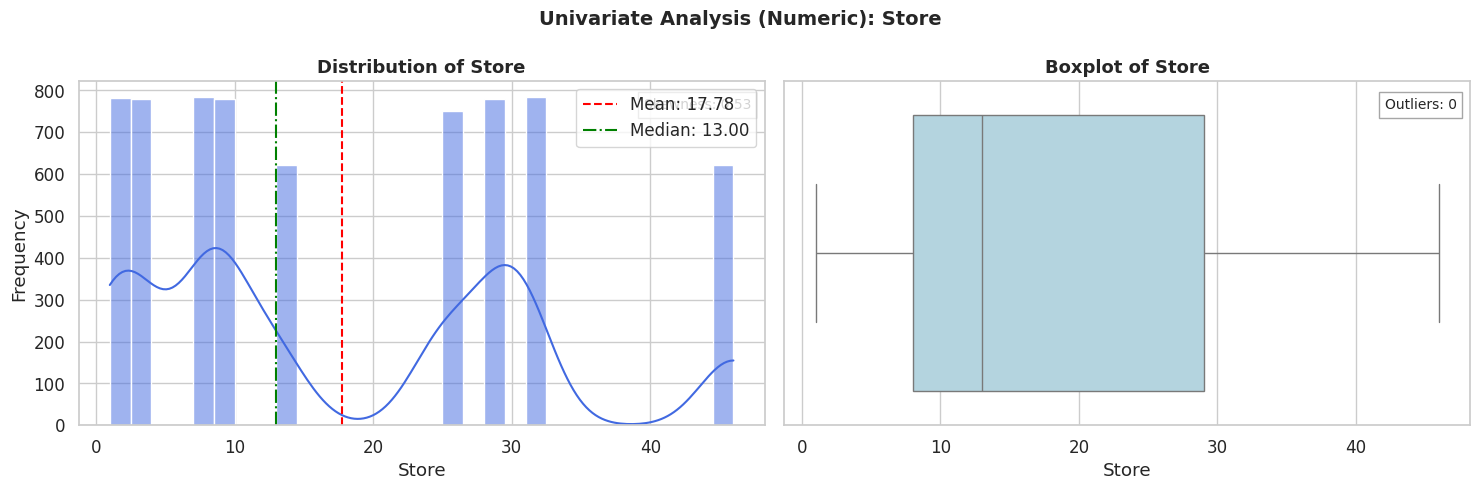

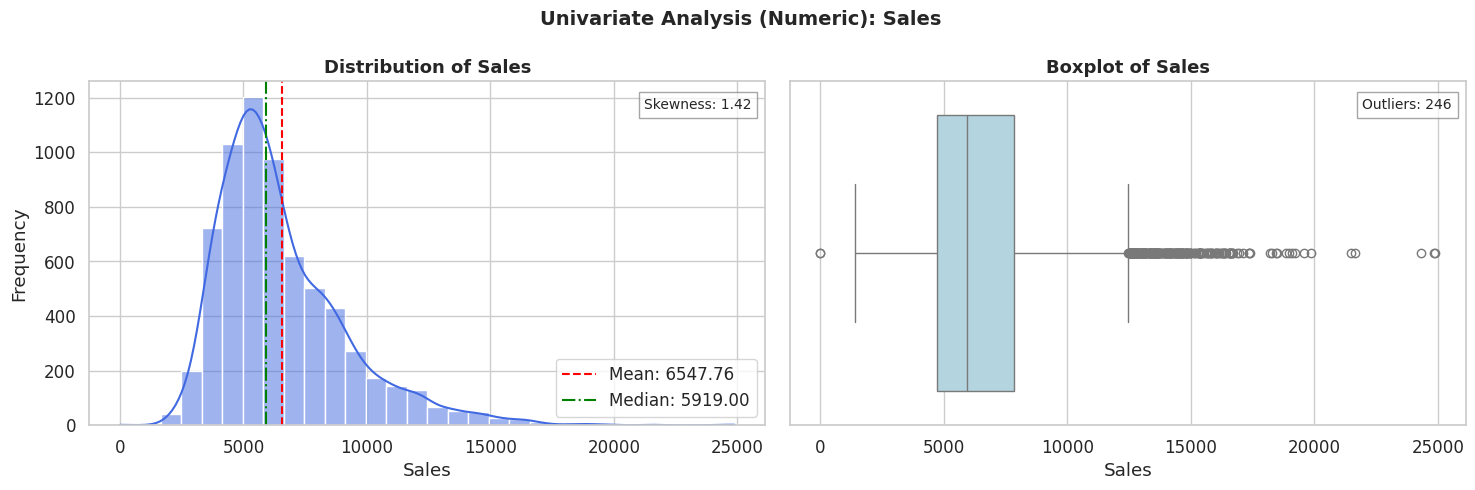

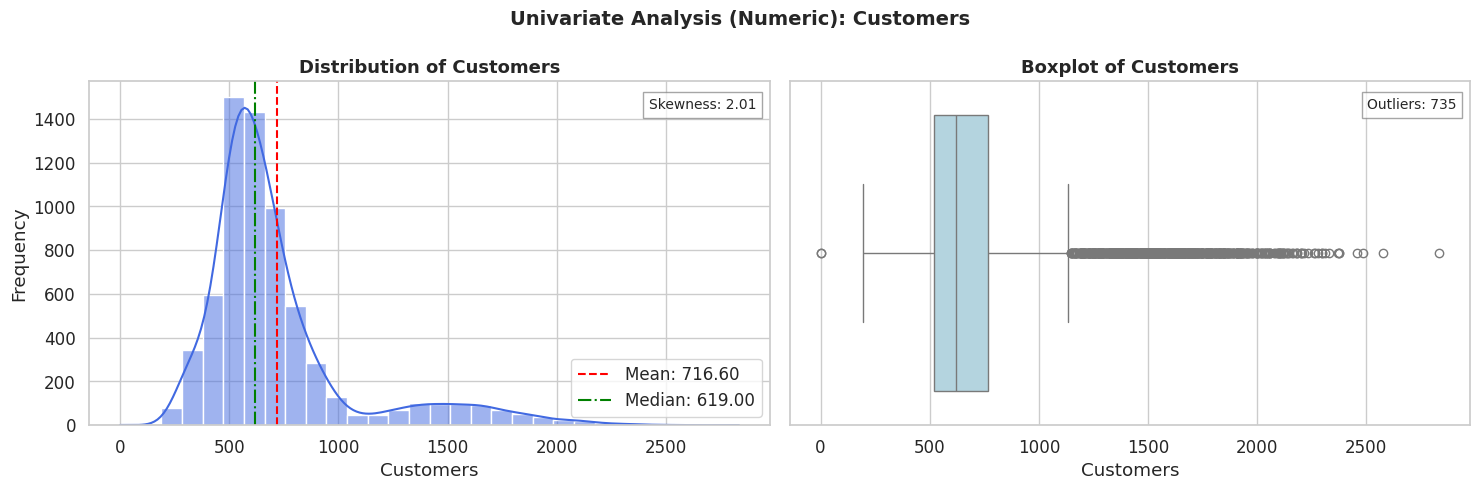

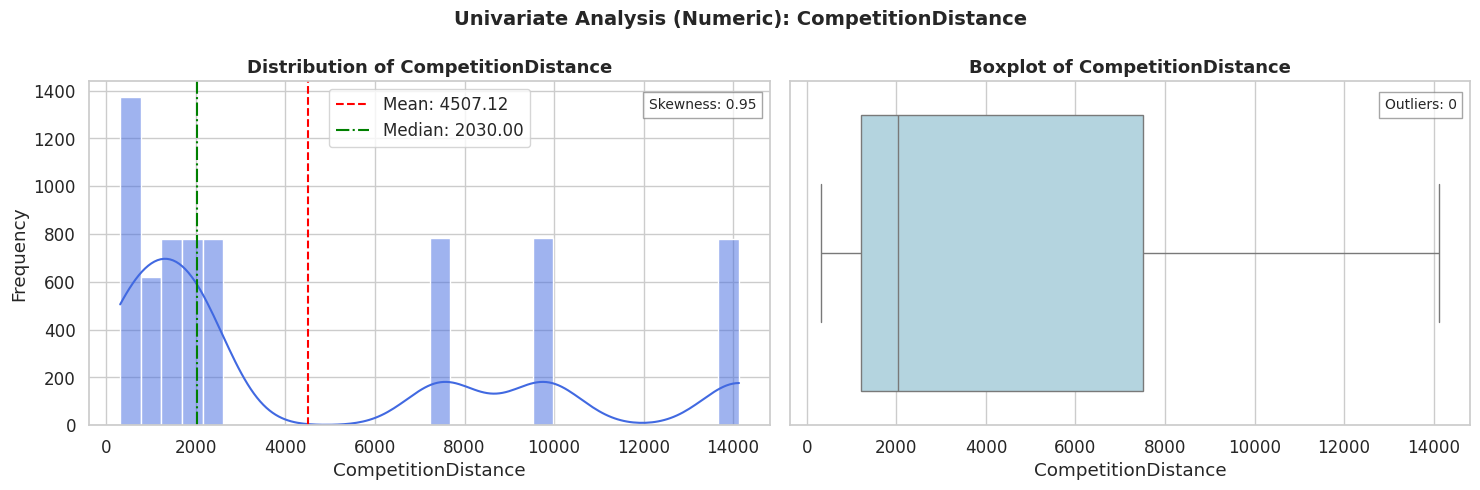

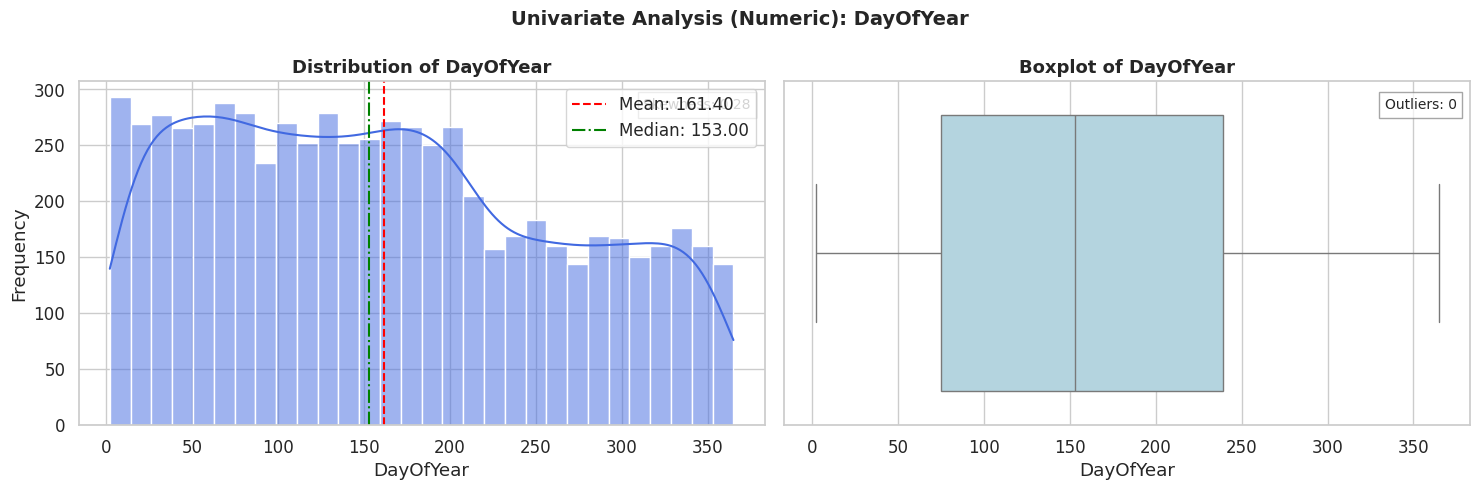

In [32]:
plot_univariate_numeric(df, num_cols, 30)

### <font color="Green">**4.3 Univariate Analysis – Categorical Columns**

In [33]:
def plot_univariate_categorical(df: pd.DataFrame, cat_cols: list):

    sns.set(style="whitegrid", font_scale=1.1)

    for col in cat_cols:

        vc = df[col].value_counts()
        total = vc.sum()
        order = vc.index

        plt.figure(figsize=(10, 5))

        # Barplot with better palette
        ax = sns.countplot(
            data=df,
            x=col,
            order=order,
            palette="viridis"
        )

        # Add value + percent annotations
        for p in ax.patches:
            height = p.get_height()
            percent = height / total * 100

            ax.annotate(
                f"{height}\n({percent:.1f}%)",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color="black"
            )

        # Rotate x labels
        plt.xticks(rotation=45, ha='right')

        # Title
        plt.title(f"Univariate Categorical Distribution: {col}", fontsize=14, weight="bold")

        plt.xlabel(col)
        plt.ylabel("Count")

        # Highlight max category by drawing a rectangle
        max_idx = vc.idxmax()
        max_pos = list(order).index(max_idx)
        max_patch = ax.patches[max_pos]

        ax.add_patch(
            plt.Rectangle(
                (max_patch.get_x(), 0),
                max_patch.get_width(),
                max_patch.get_height(),
                fill=False,
                edgecolor='red',
                linewidth=2
            )
        )

        plt.tight_layout()
        plt.show()


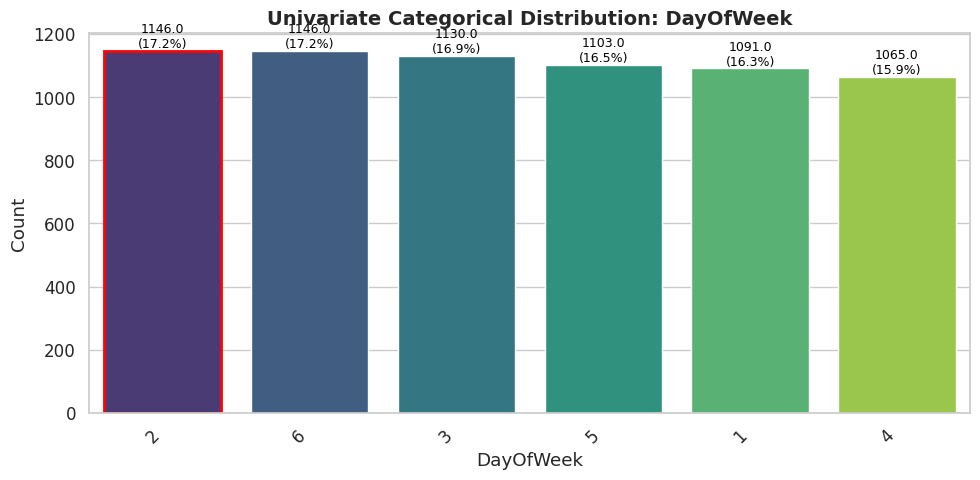

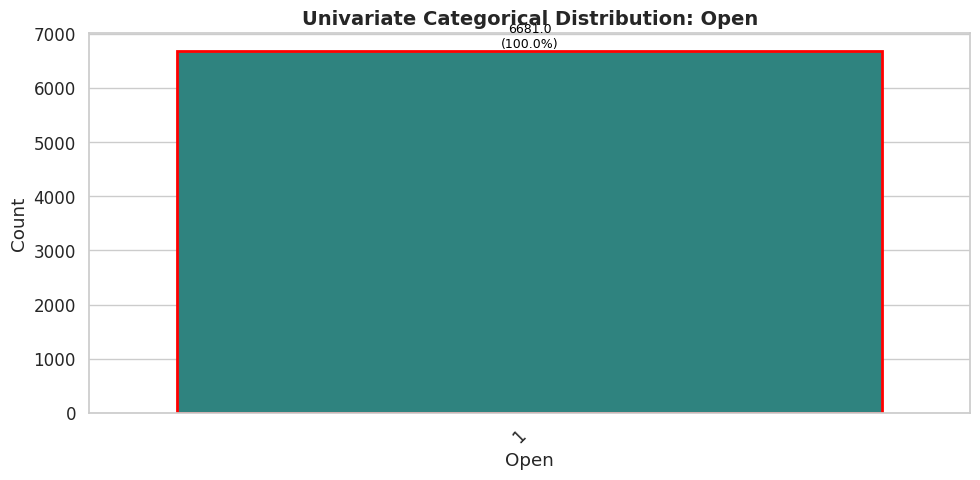

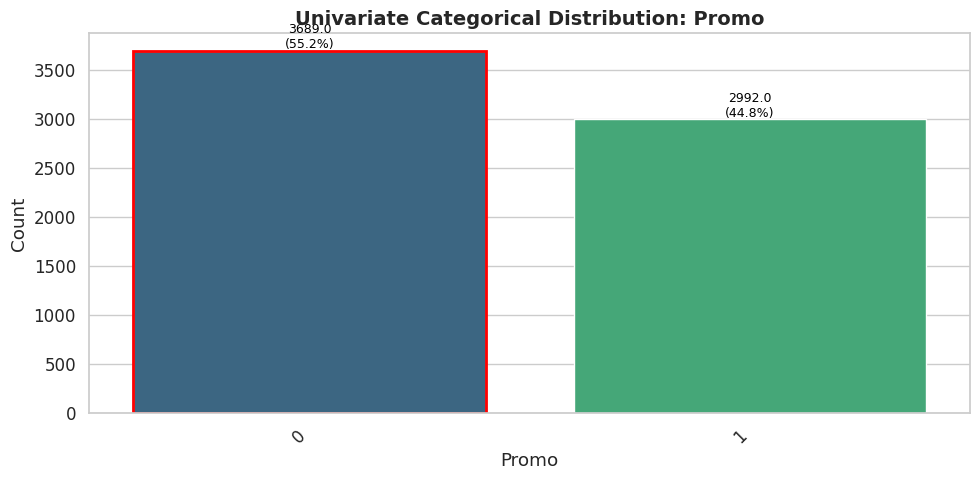

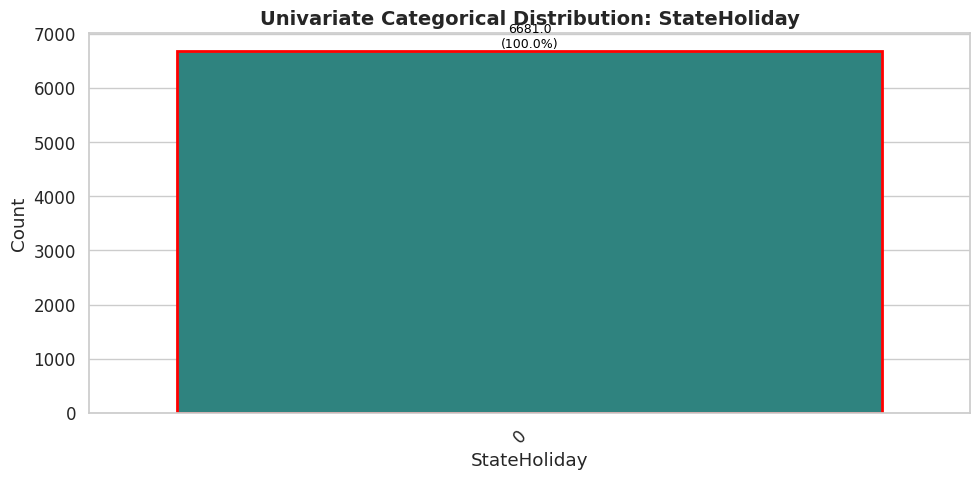

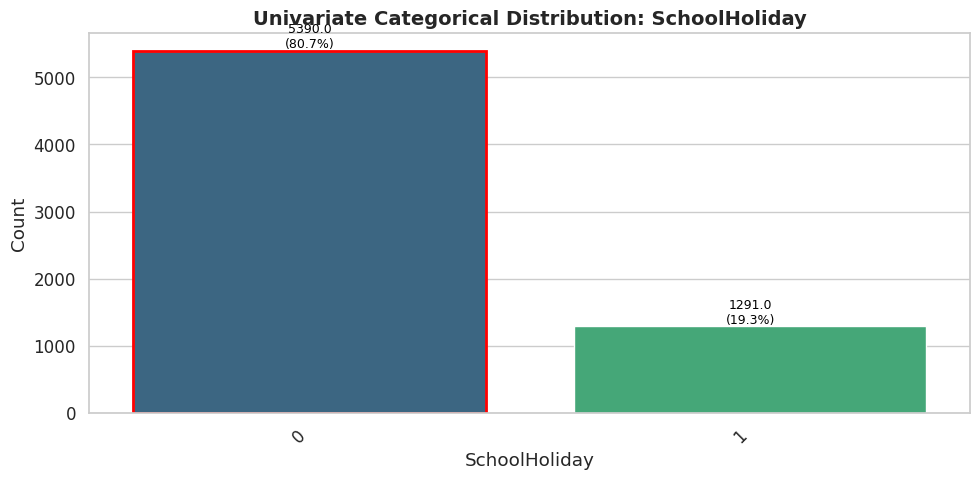

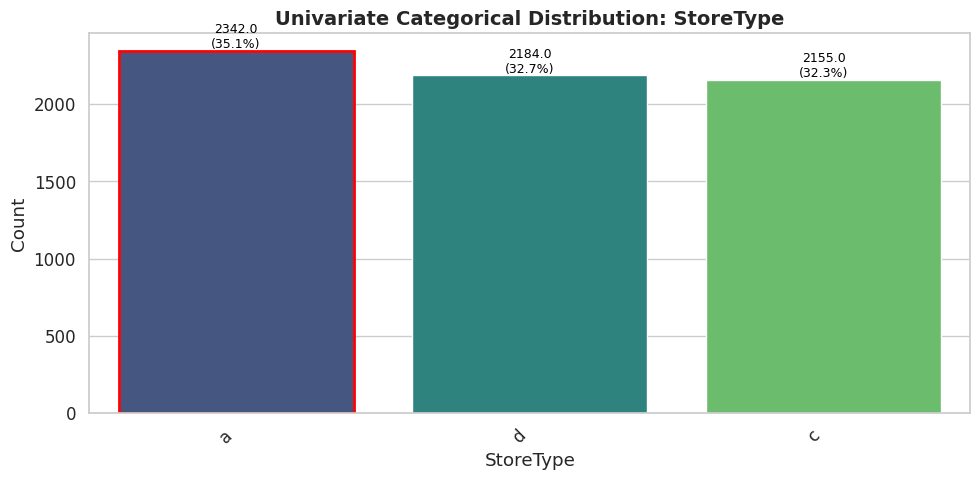

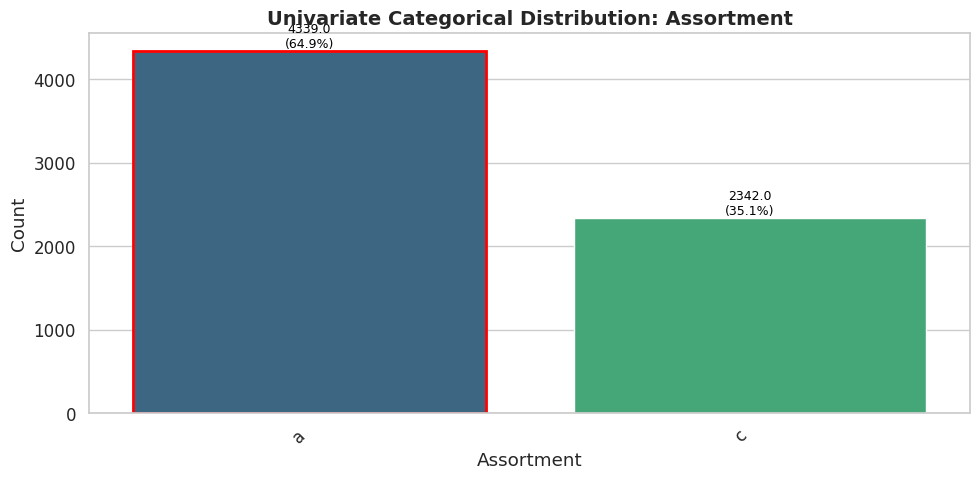

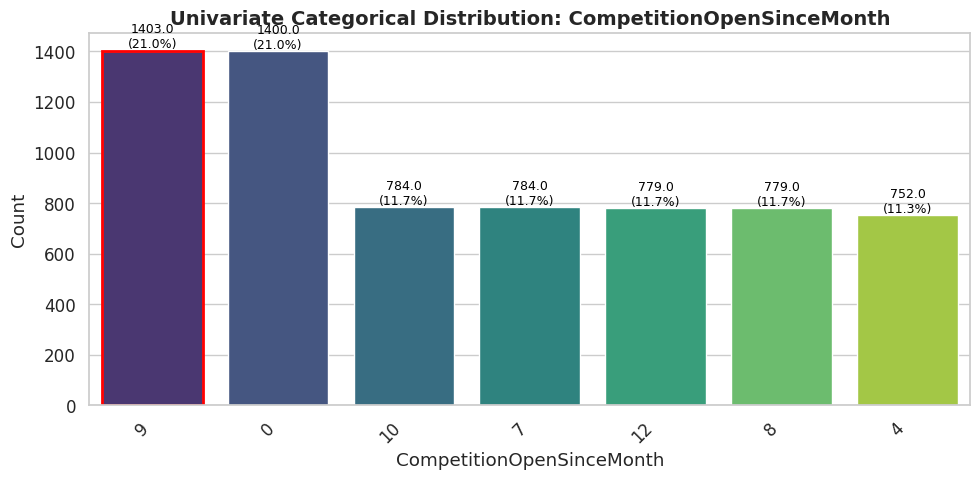

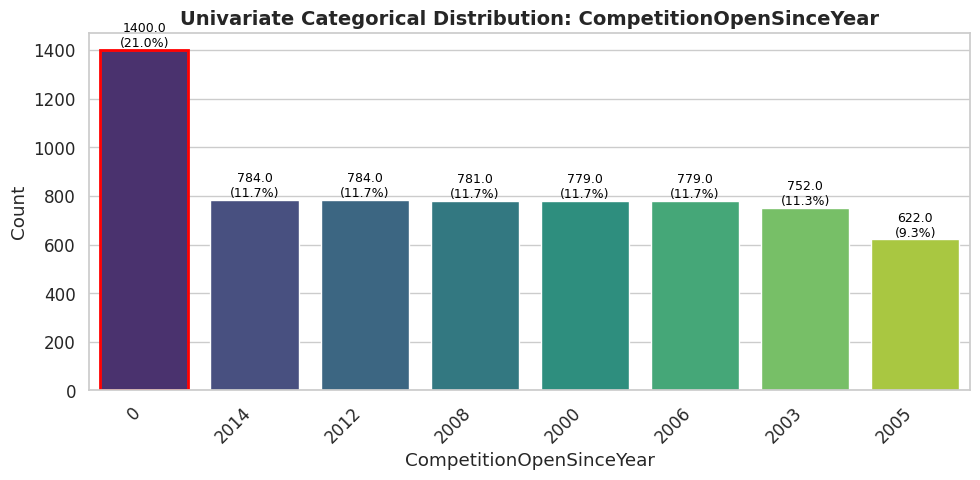

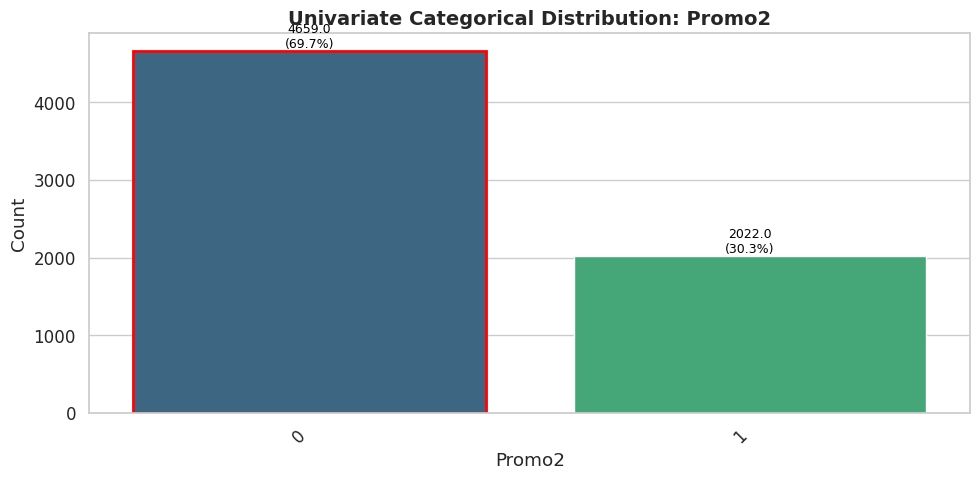

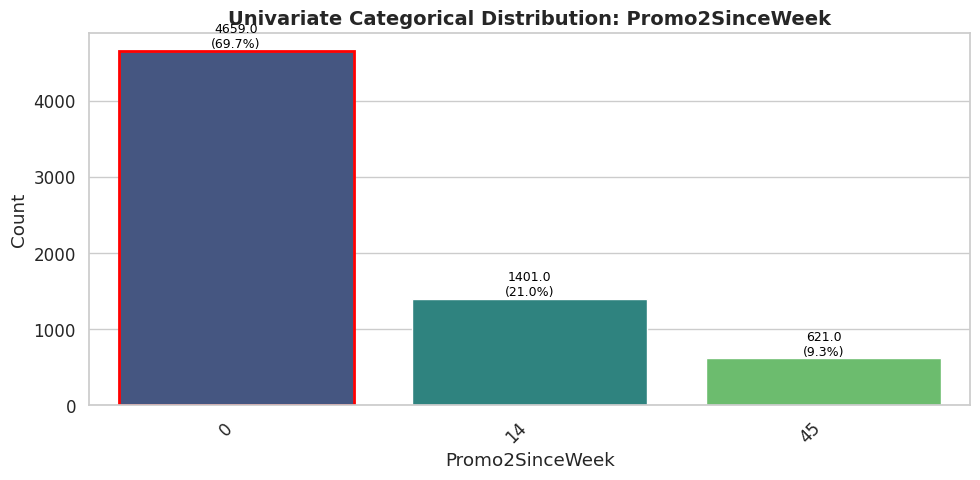

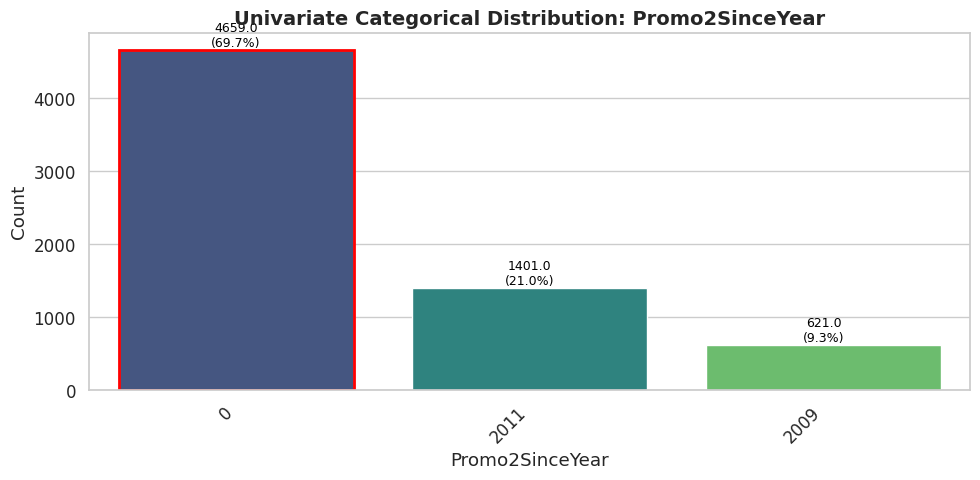

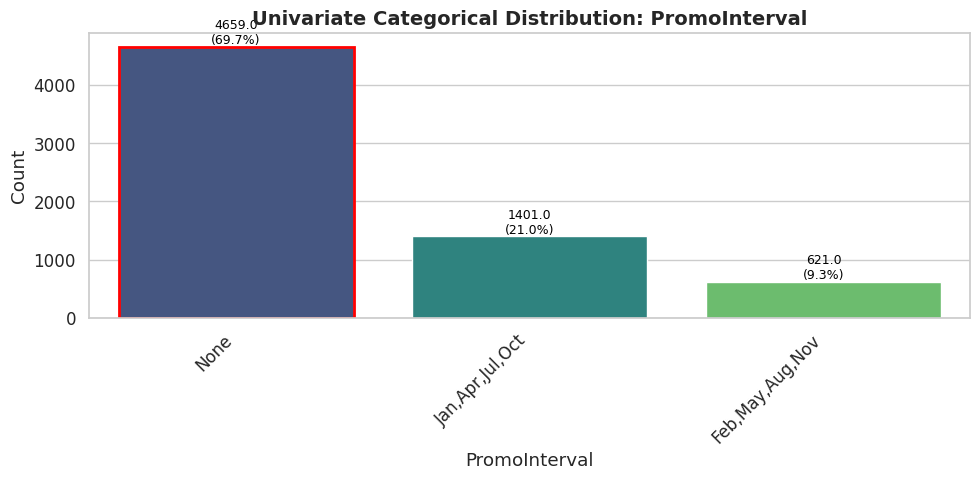

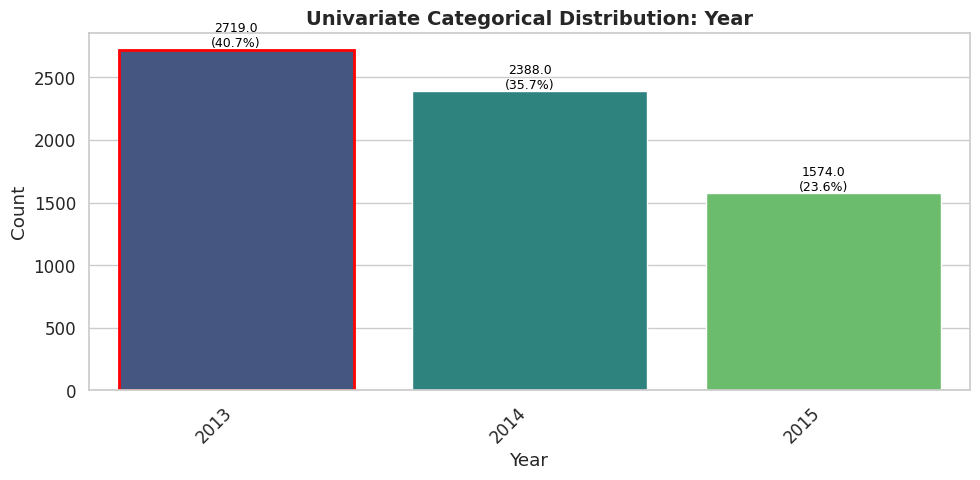

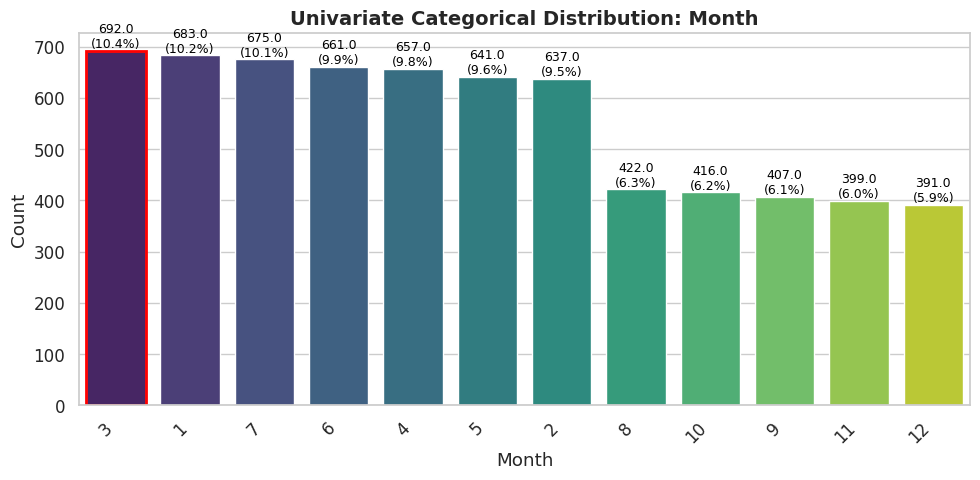

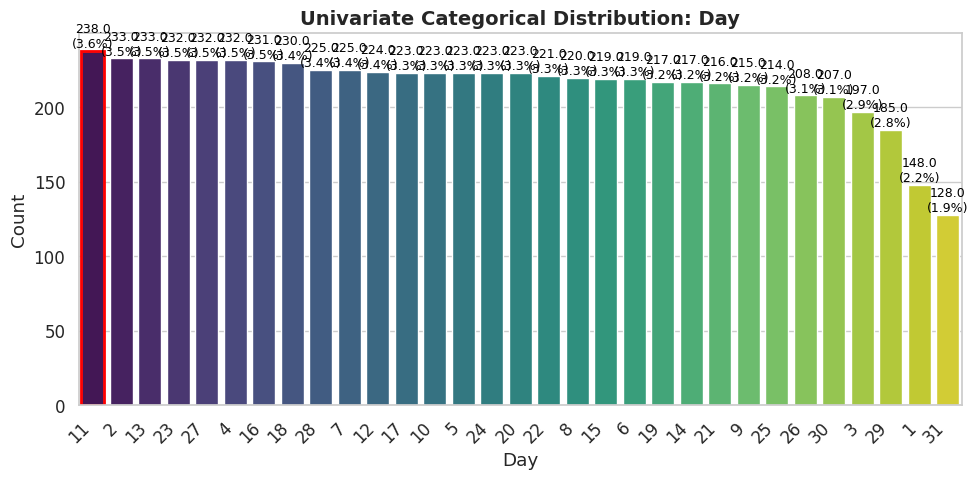

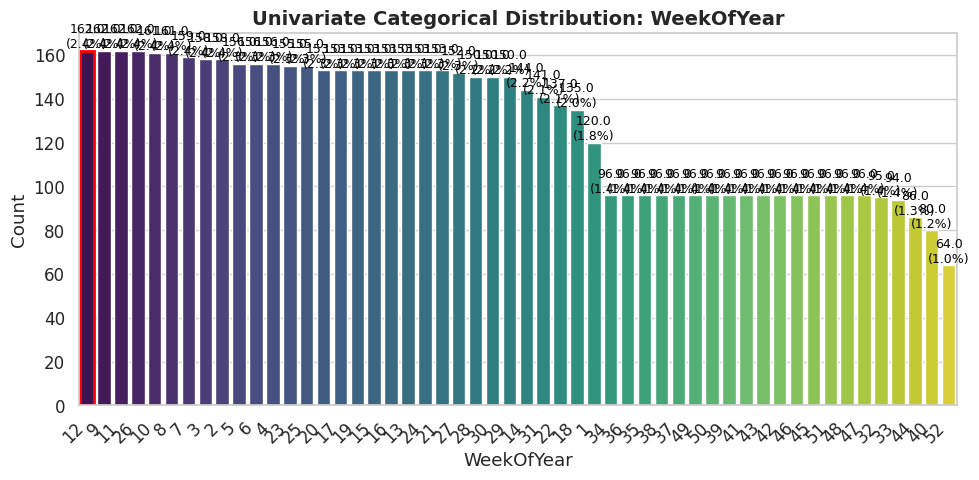

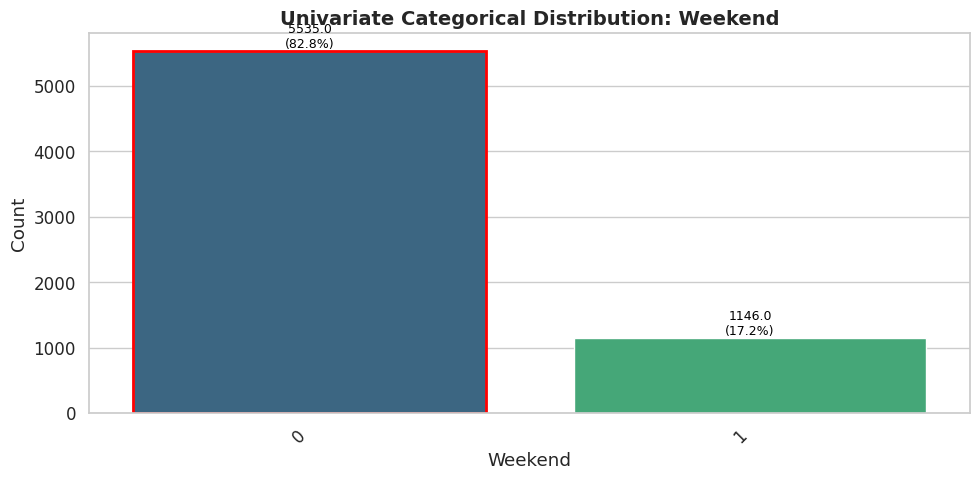

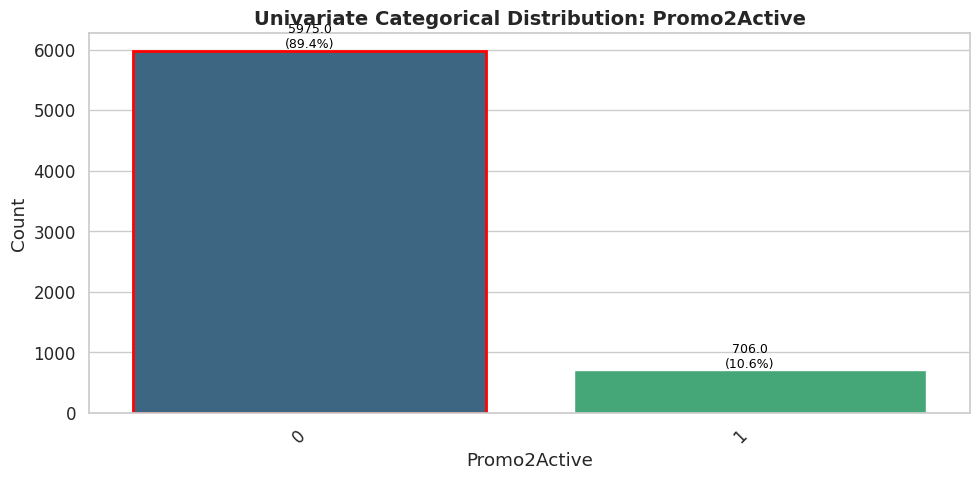

In [34]:
plot_univariate_categorical(df, cat_cols)

### <font color="Green">**4.4 Bivariate Analysis Sales Focused**

##### <font color="DrakRed">**4.4.1 Impact of Sales due to following categorical variables**
*   <font color="Magenta">Sales by DayOfWeek
*   <font color="Magenta">Sales by Promo / Promo2
*   <font color="Magenta">Sales by StoreType
*   <font color="Magenta">Sales by Assortment
*   <font color="Magenta">Sales by StateHoliday
*   <font color="Magenta">Sales by SchoolHoliday

In [35]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)
# - Left: boxplot of Sales by category (optionally with hue)
# - Right: barplot of mean Sales with 95% CI (optionally with hue)
def plot_sales_by_category(
    df: pd.DataFrame,
    cat_cols: list,
    sales_col: str = "Sales",
    hue: str = None,
    top_n_categories: int = None
):

    for col in cat_cols:

        if col not in df.columns:
            continue

        # Drop NaNs on relevant columns
        plot_df = df[[col, sales_col] + ([hue] if hue else [])].dropna()

        # Optionally limit to top N categories by frequency
        if top_n_categories is not None and plot_df[col].nunique() > top_n_categories:
            top_cats = plot_df[col].value_counts().nlargest(top_n_categories).index
            plot_df = plot_df[plot_df[col].isin(top_cats)]

        # Category order by median Sales (for nicer ordering)
        order = (
            plot_df.groupby(col)[sales_col]
            .median()
            .sort_values(ascending=False)
            .index
        )

        # Create subplots: boxplot + barplot side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

        sns.boxplot(
            data=plot_df,
            x=col,
            y=sales_col,
            hue=hue,
            order=order,
            ax=axes[0]
        )
        axes[0].set_title(f"{sales_col} by {col} (distribution)")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel(sales_col)
        axes[0].tick_params(axis="x", rotation=30)

        # Move legend out of the way (only on left plot)
        if hue is not None:
            axes[0].legend(loc="upper right", title=hue)
        else:
            axes[0].legend_.remove() if axes[0].get_legend() else None

        sns.barplot(
            data=plot_df,
            x=col,
            y=sales_col,
            hue=hue,
            order=order,
            estimator=np.mean,
            ci=95,
            ax=axes[1]
        )
        axes[1].set_title(f"Mean {sales_col} by {col} (±95% CI)")
        axes[1].set_xlabel(col)
        axes[1].set_ylabel(f"Mean {sales_col}")
        axes[1].tick_params(axis="x", rotation=30)

        if hue is not None:
            axes[1].legend(loc="upper right", title=hue)
        else:
            axes[1].legend_.remove() if axes[1].get_legend() else None

        plt.suptitle(f"{sales_col} vs {col}", y=1.03, fontsize=15)
        plt.tight_layout()
        plt.show()

        group_cols = [col] + ([hue] if hue else [])
        summary = (
            plot_df
            .groupby(group_cols)[sales_col]
            .agg(["count", "mean", "median", "std"])
            .round(2)
            .reset_index()
        )
        print(f"Summary stats for {sales_col} by {col}" + (f" and {hue}" if hue else "") + ":\n")
        display(summary)
        print("-" * 80)


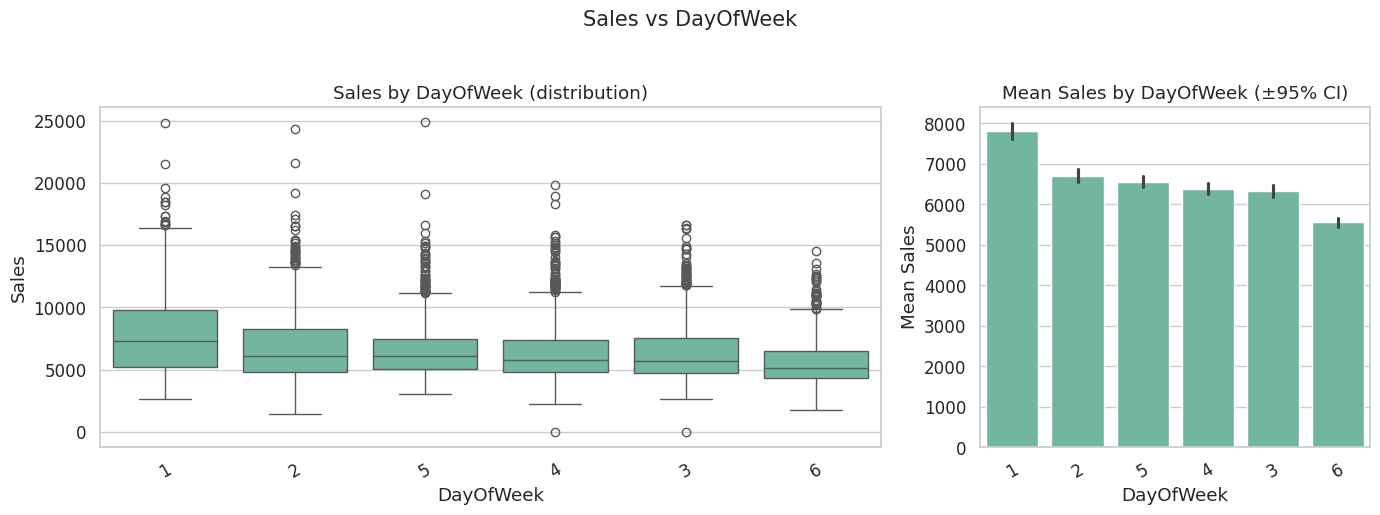

Summary stats for Sales by DayOfWeek:



DayOfWeek  count     mean  median      std
0          1   1091  7805.09  7328.0  3297.16
1          2   1146  6708.53  6122.5  2750.98
2          3   1130  6324.29  5723.5  2371.06
3          4   1065  6384.76  5789.0  2424.38
4          5   1103  6558.65  6069.0  2323.75
5          6   1146  5551.36  5153.0  1946.46

--------------------------------------------------------------------------------


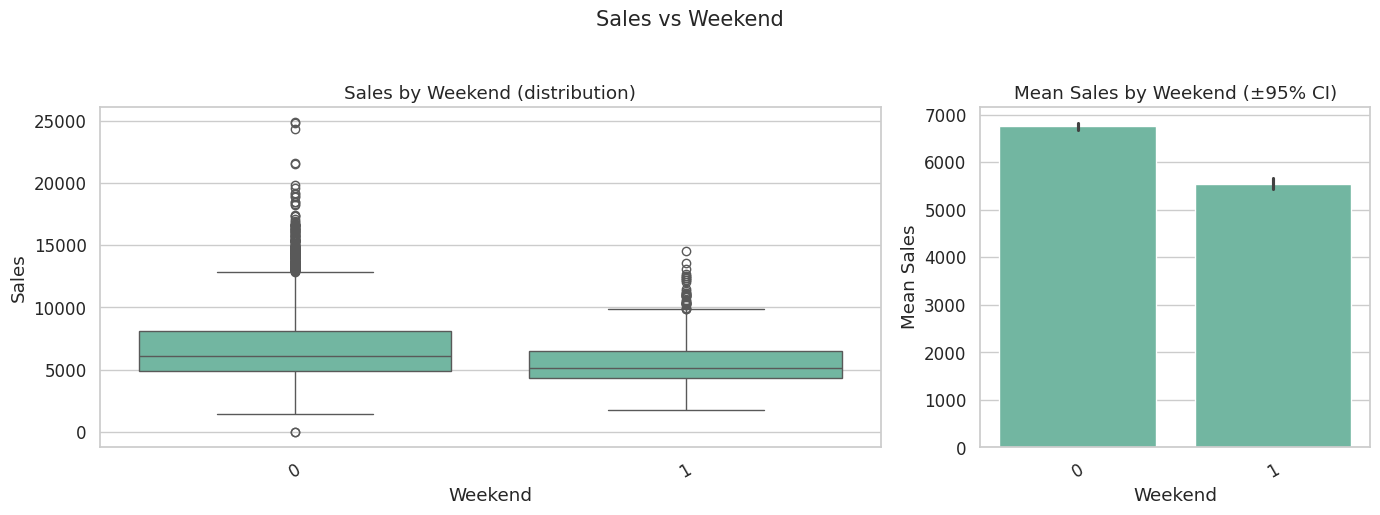

Summary stats for Sales by Weekend:



Weekend  count     mean  median      std
0        0   5535  6754.06  6087.0  2710.93
1        1   1146  5551.36  5153.0  1946.46

--------------------------------------------------------------------------------


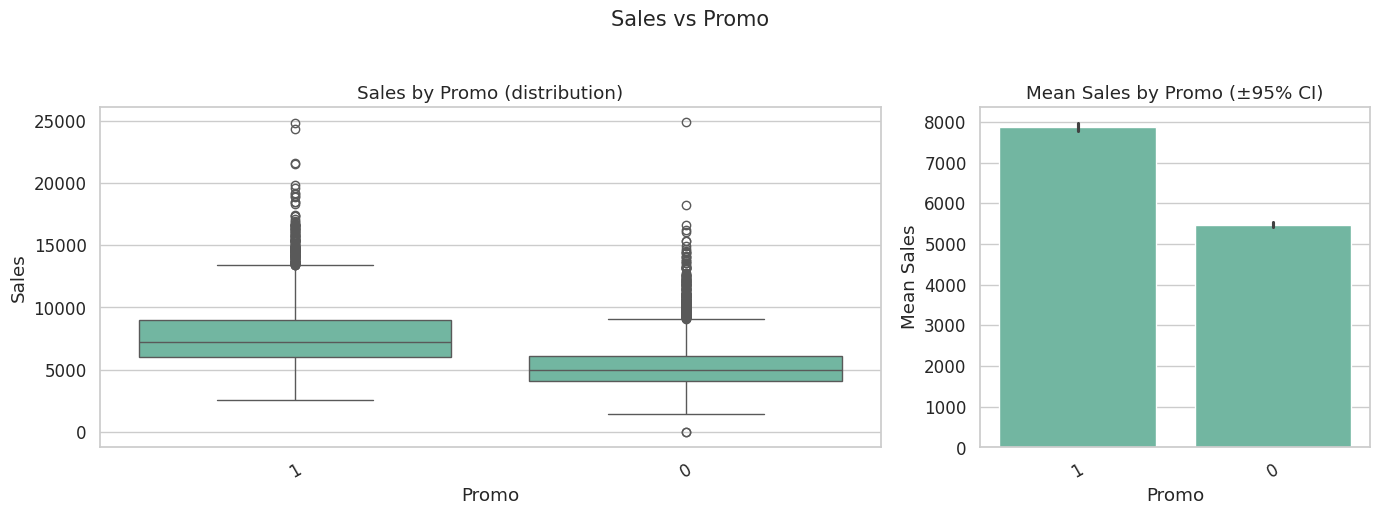

Summary stats for Sales by Promo:



Promo  count     mean  median      std
0      0   3689  5474.32  5010.0  2060.20
1      1   2992  7871.27  7225.5  2664.59

--------------------------------------------------------------------------------


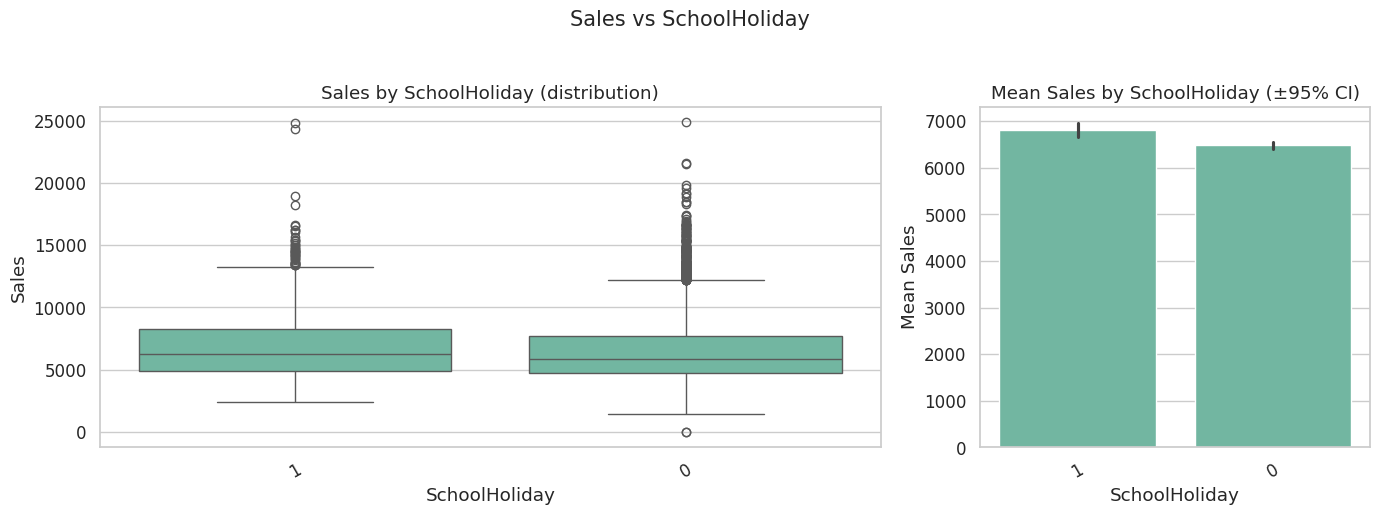

Summary stats for Sales by SchoolHoliday:



SchoolHoliday  count     mean  median      std
0              0   5390  6484.24  5862.5  2605.86
1              1   1291  6812.97  6219.0  2738.59

--------------------------------------------------------------------------------


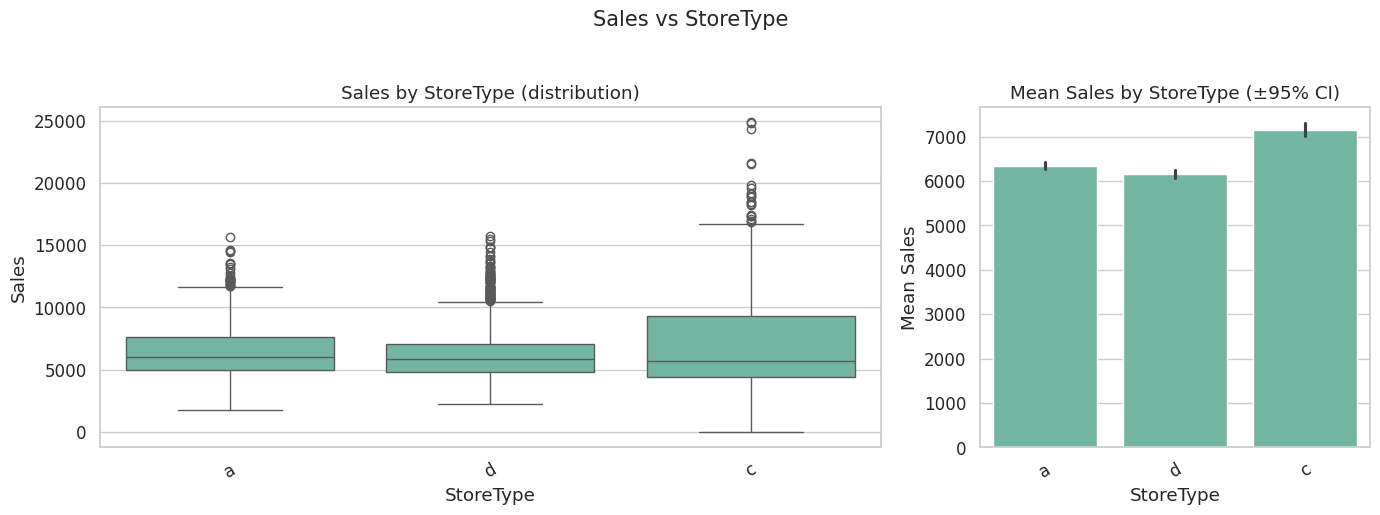

Summary stats for Sales by StoreType:



StoreType  count     mean  median      std
0         a   2342  6346.36  6051.5  2008.04
1         c   2155  7156.63  5731.0  3536.62
2         d   2184  6162.95  5872.5  2005.84

--------------------------------------------------------------------------------


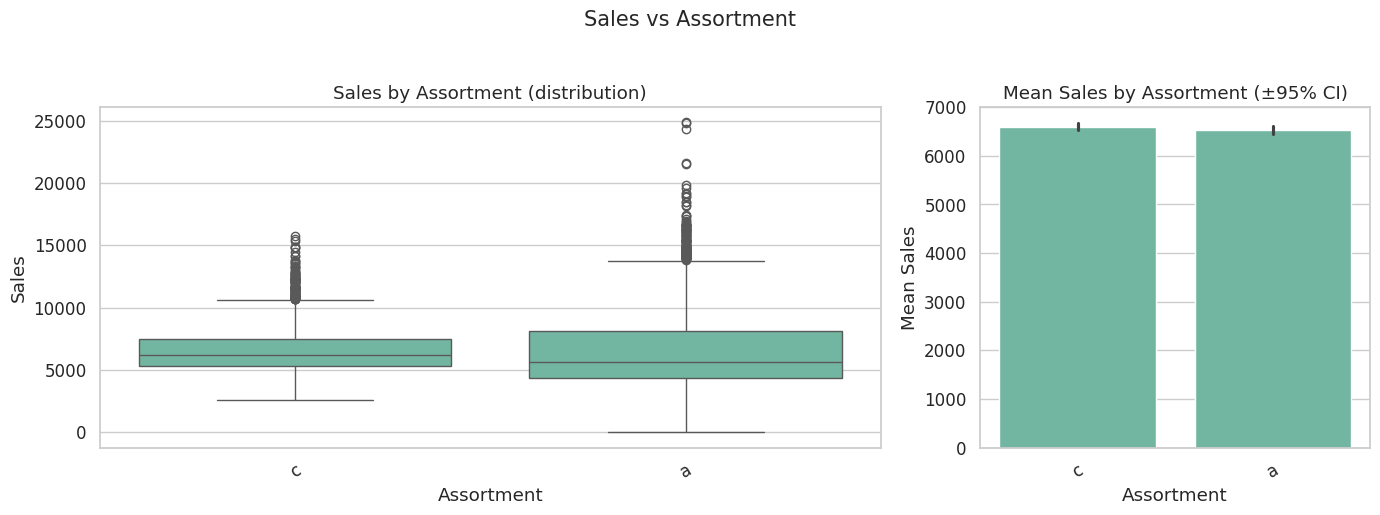

Summary stats for Sales by Assortment:



Assortment  count     mean  median      std
0          a   4339  6522.29  5637.0  2969.49
1          c   2342  6594.95  6170.5  1862.58

--------------------------------------------------------------------------------


In [36]:
# Categories for clarity
cat_for_sales = [c for c in [
    "DayOfWeek", "Weekend", "Promo", "Promo2"
    "StateHoliday", "SchoolHoliday", "StoreType", "Assortment"
] if c in df.columns]

plot_sales_by_category(df, cat_for_sales, sales_col="Sales")

### <font color="Green"> **4.5. Customer and Sales corelation**

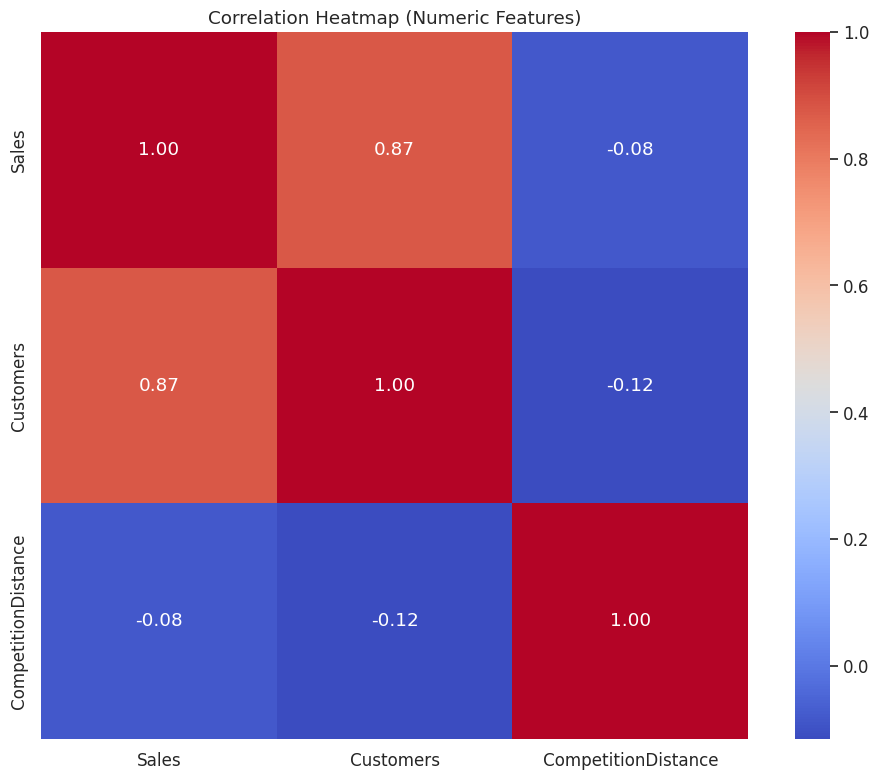

In [37]:
def plot_correlation_heatmap(df: pd.DataFrame, num_cols: list):
    corr_df = df[num_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()

# Choose a subset for clarity:
num_for_corr = [c for c in ["Sales", "Customers", "CompetitionDistance"] if c in df.columns]

plot_correlation_heatmap(df, num_for_corr)

. <font color="Magenta">**Sales:** <font color="Black">Distributed Normally

. <font color="Magenta">**Customers:** <font color="Black">Distributed Normally

. <font color="Magenta">**DayOfweek:** <font color="Black">Sales are strongest early in the week (especially Monday). No sales on Sunday, maybe stored are closed

. <font color="Magenta">**Weekend:** <font color="Black">Weekend has not impacted sales data

. <font color="Magenta">**Open:** <font color="Black">Data already filterd for Stores opened

. <font color="Magenta">**Year:** <font color="Black">Data belongs to 2013, 2014, 2015.

. <font color="Magenta">**StateHoiday:** <font color="Black">State holidays have not impacted sales

. <font color="Magenta">**SchoolHoliday:** <font color="Black">School holidays also have not impacted sales

. <font color="Magenta">**StoreType:** <font color="Black">Maximum sales happened on StoreType - a

. <font color="Magenta">**Sales vs Customer:** <font color="Black">Sales and Customers are strongly corelated

. <font color="Magenta">**Sales vs CompetitionDistance:** <font color="Black">Sales more as the as competitiors are far away

. <font color="Magenta">**Sales vs Promo:** <font color="Black">Sales is postivitely impacted by Promo

. <font color="Magenta">**Sales vs Promo2:** <font color="Black">Sales not much impacted by Promo2

### <font color="Green">**4.5 TimeSeries Plots – Sales over Time (Per Store)**

In [38]:
# Total daily sales over time (for selected stores)
def plot_sales_over_time(df, key_stores=KEY_STORES):

    available = df["Store"].unique()
    store_ids = [s for s in key_stores if s in available]

    n_stores = len(store_ids)

    fig, axes = plt.subplots(n_stores, 1, figsize=(15, 3 * n_stores), sharex=True)

    # When n_stores == 1, axes is a single Axes object, make it list-like
    if n_stores == 1:
        axes = [axes]

    for i, store_id in enumerate(store_ids):
        ax = axes[i]
        df_s = df[df["Store"] == store_id].sort_values("Date")

        ax.plot(df_s["Date"], df_s["Sales"])
        ax.set_title(f"Store {store_id}")
        ax.set_ylabel("Sales")

        # Only label x-axis on the last subplot to avoid clutter
        if i == n_stores - 1:
            ax.set_xlabel("Date")
        else:
            ax.set_xlabel("")

    plt.suptitle("Sales Over Time for Key Stores (One Store per Row)", y=1.02)
    plt.tight_layout()
    plt.show()

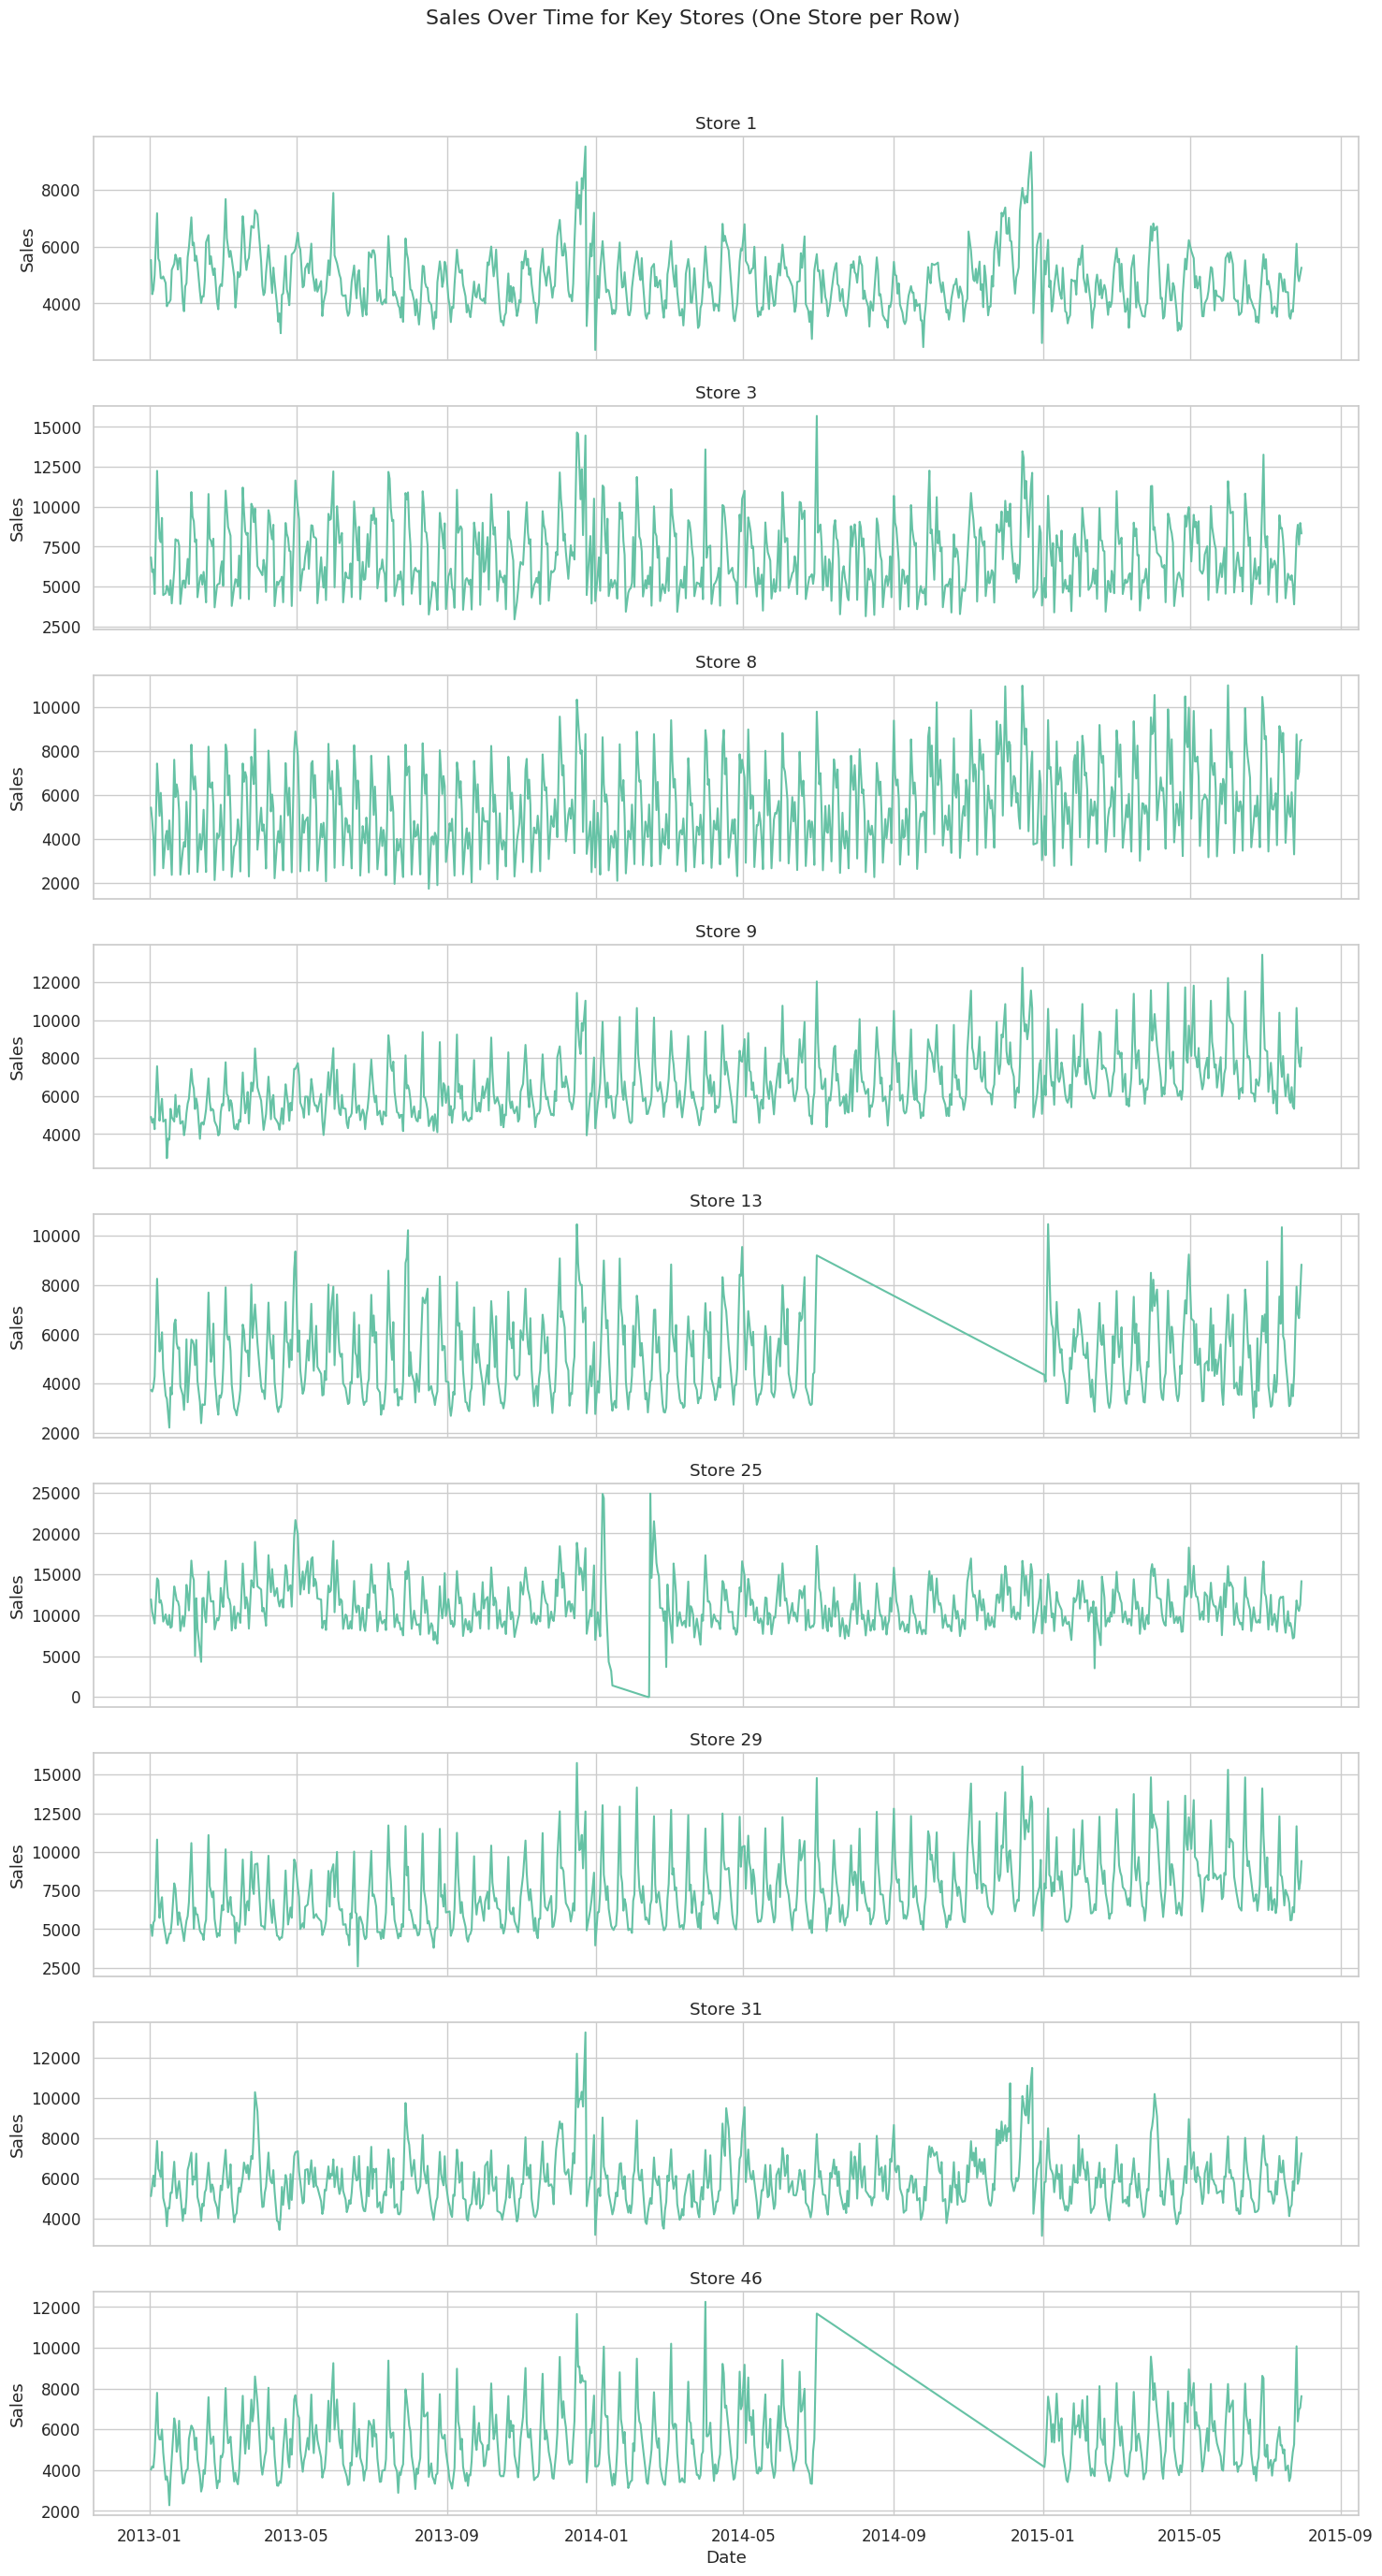

In [39]:
KEY_STORES = [1, 3, 8, 9, 13, 25, 29, 31, 46]
plot_sales_over_time(df, KEY_STORES)

# <font color="Orange">**5 Outlier Detection & Removal (99th percentile)**

### <font color="Green">**5.1 Describe Data**

##### <font color="DarkRed">**5.1.1 Describe Sales and Customers Data**


In [40]:
df[["Sales", "Customers"]].describe().T.round(2)

count     mean      std  min     25%     50%     75%      max
Sales      6681.0  6547.76  2635.02  0.0  4738.0  5919.0  7828.0  24882.0
Customers  6681.0   716.60   353.47  0.0   517.0   619.0   765.0   2835.0

### <font color="Green">**5.2 Remove Outliers**


##### <font color="DarkRed">**5.2.1 Function to remove 99th Percentile Outliers on Sales and Customers**


In [41]:
# Function to remove 99th percentile outliers
def remove_outliers(df):

      df = df.copy()

      all_stores = sorted(df["Store"].unique())

      cleaned_parts = []
      total_before = len(df)

      for store_id in all_stores:

          store_data = df[df["Store"] == store_id].copy()
          before_store = len(store_data)

          sales_threshold = store_data["Sales"].quantile(0.99)
          store_data = store_data[store_data["Sales"] <= sales_threshold]

          cust_threshold = store_data["Customers"].quantile(0.99)
          store_data = store_data[store_data["Customers"] <= cust_threshold]

          after_store = len(store_data)
          removed_store = before_store - after_store
          print(f"Store {store_id}: removed {removed_store} outlier rows.")

          cleaned_parts.append(store_data)

      # Combine all stores back together
      cleaned_df = pd.concat(cleaned_parts, ignore_index=True)
      total_after = len(cleaned_df)

      print(f"\nTotal rows before: {total_before}")
      print(f"Total rows after : {total_after}")
      print(f"Total removed    : {total_before - total_after}")

      return cleaned_df

In [42]:
#df_no_outliers = remove_outliers(df)

def remove_outliers_99(group, col='Sales'):
    thresh = group[col].quantile(0.99)
    return group[group[col] <= thresh]

before_rows = len(df)
df_no_outliers = df.groupby('Store', group_keys=False).apply(remove_outliers_99, col='Sales')
after_rows = len(df_no_outliers)

print(f"Removed {before_rows - after_rows} outlier rows (Sales > 99th percentile per store).")

Removed 70 outlier rows (Sales > 99th percentile per store).


##### <font color="DarkRed">**5.2.2 Describe after Outliers removed**

In [43]:
df_no_outliers[["Sales", "Customers"]].describe().T.round(2)

count     mean      std  min     25%     50%     75%      max
Sales      6611.0  6481.96  2537.48  0.0  4727.0  5893.0  7733.5  19080.0
Customers  6611.0   712.16   349.01  0.0   517.0   615.0   759.0   2376.0

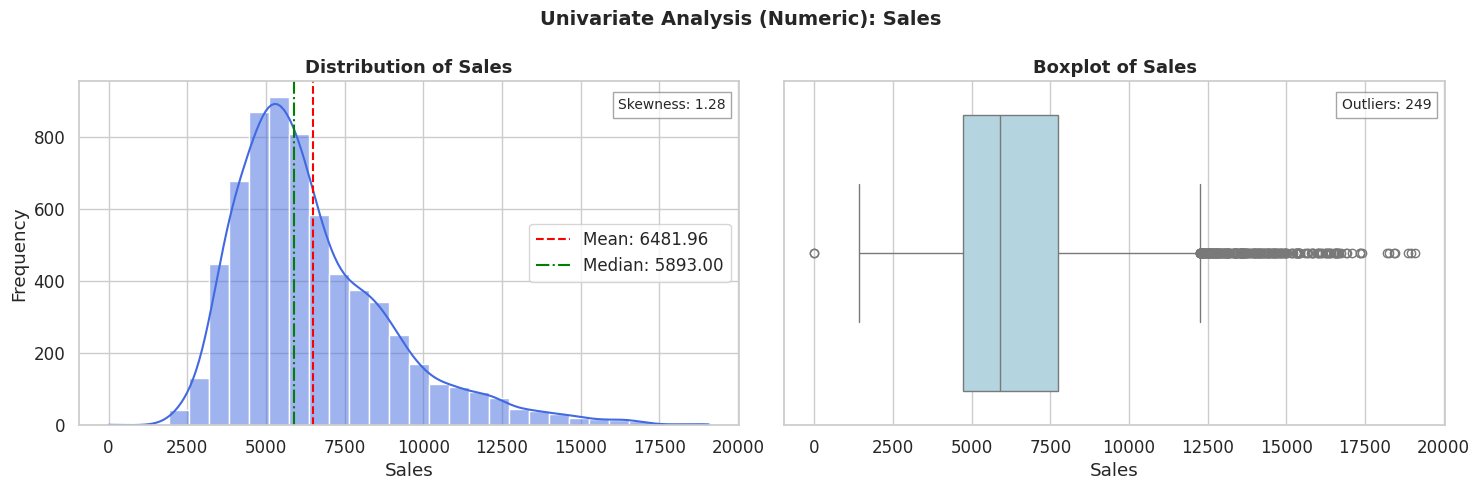

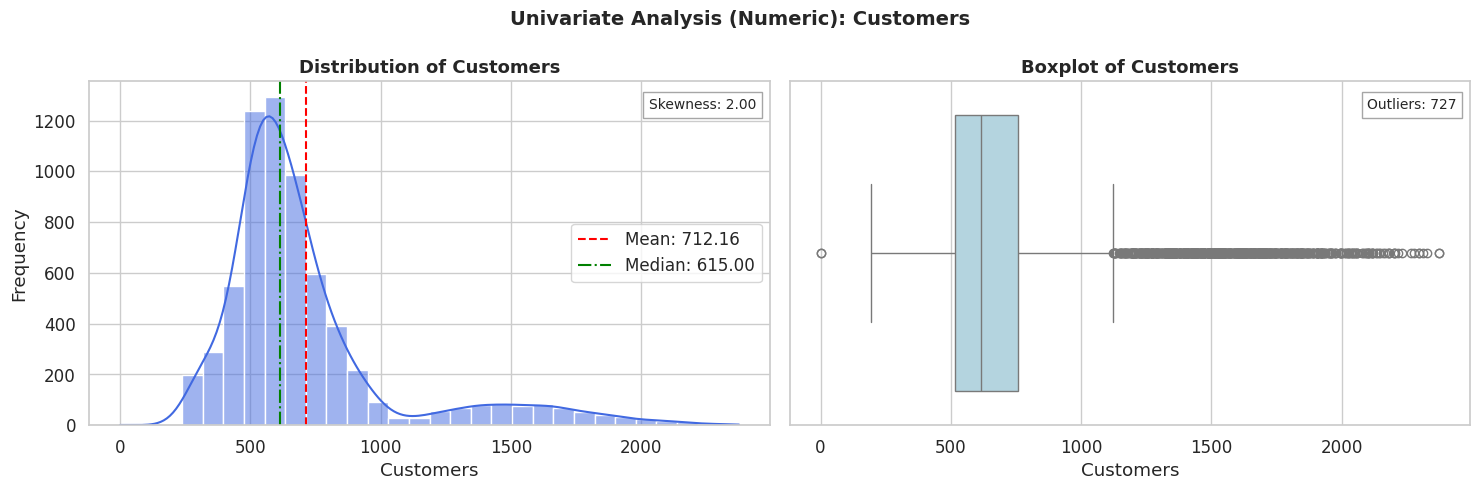

In [44]:
plot_univariate_numeric(df_no_outliers, ['Sales', 'Customers'], 30)

# <font color="Orange">**6 Data Standardization**

### <font color="Green">**6.1 Standardize Sales and Customers Data**



##### <font color="DarkRed">**6.1.1 Standardize Sales and Customers per store**

In [45]:
def standardize_per_store(df, cols=('Sales', 'Customers')):
    df_std = df_no_outliers.copy()
    scalers = {}
    df['Sales_Std'] = np.nan
    df['Customers_Ctd'] = np.nan

    for store_id, group in df_std.groupby('Store'):
      scaler = StandardScaler()
      scaled = scaler.fit_transform(group[['Sales', 'Customers']])
      df_std.loc[group.index, 'Sales_Std'] = scaled[:, 0]
      df_std.loc[group.index, 'Customers_Std'] = scaled[:, 1]
      scalers[store_id] = scaler
    return df_std, scalers

In [46]:
df_std, scalers = standardize_per_store(df_no_outliers)

df_std[['Store', 'Date', 'Sales', 'Sales_Std', 'Customers', 'Customers_Std']].head()

Store       Date  Sales  Sales_Std  Customers  Customers_Std
8092      1 2013-01-02   5530   0.861000        668       1.276518
8083      1 2013-01-03   4327  -0.418370        578       0.212804
8074      1 2013-01-04   4486  -0.249276        619       0.697385
8065      1 2013-01-05   4997   0.294164        635       0.886490
8047      1 2013-01-07   7176   2.611494        785       2.659346

### <font color="Green">**6.2 Stationarity Test**

##### <font color="DarkRed">**6.2.1 ADF Function to test Stationarity**



In [47]:
def adf_test(series, name):

    result = adfuller(series, autolag="AIC")

    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '# Lags Used': result[2],
        '# Observations': result[3]
    }

    print(f"\n--- ADF test on {name} ---")
    for k, v in output.items():
            print(f'   {k}: {v}')

    if result[1] <= 0.05:
        print("Conclusion : Reject H0 → series is likely STATIONARY (at 5% level).")
    else:
        print("Conclusion : Fail to reject H0 → series is likely NON-STATIONARY (at 5% level).")

    return output

##### <font color="DarkRed">**6.2.2 Stationarity Test Across all Stores**

In [48]:
store_stationarity = {}

for store_id, group in df_std.groupby('Store'):
      store_data = group.sort_values('Date').set_index('Date')
      # ADF Test
      adf_sales = adf_test(store_data['Sales_Std'], name=f'Store {store_id} Sales_Std')
      adf_cust = adf_test(store_data['Customers_Std'], name=f'Store {store_id} Customers_Std')
      #store_stationarity[store_id] = {
      #  'sales_pvalue': adf_sales['p-value'],
      #  'customers_pvalue': adf_cust['p-value']
      #}


--- ADF test on Store 1 Sales_Std ---
   Test Statistic: -5.650162686301225
   p-value: 9.902597940381905e-07
   # Lags Used: 13
   # Observations: 759
Conclusion : Reject H0 → series is likely STATIONARY (at 5% level).

--- ADF test on Store 1 Customers_Std ---
   Test Statistic: -4.245524911116645
   p-value: 0.0005512528207384574
   # Lags Used: 13
   # Observations: 759
Conclusion : Reject H0 → series is likely STATIONARY (at 5% level).

--- ADF test on Store 3 Sales_Std ---
   Test Statistic: -6.518123669539579
   p-value: 1.0586955229965258e-08
   # Lags Used: 15
   # Observations: 755
Conclusion : Reject H0 → series is likely STATIONARY (at 5% level).

--- ADF test on Store 3 Customers_Std ---
   Test Statistic: -5.890508054000834
   p-value: 2.932060538710515e-07
   # Lags Used: 16
   # Observations: 754
Conclusion : Reject H0 → series is likely STATIONARY (at 5% level).

--- ADF test on Store 8 Sales_Std ---
   Test Statistic: -3.068141503067911
   p-value: 0.0290024693380910

### <font color="Green">**6.3 Cointegration Test (Johansen) between Sales and Customers**

##### <font color="DarkRed">**6.3.1 Johansen Test Function**

In [49]:
# johansen test Function
# endog: DataFrame with multiple columns (e.g., Sales_std, Customers_std)
def johansen_test(endog, det_order=0, k_ar_diff=1):
    result = coint_johansen(endog.values, det_order, k_ar_diff)
    print("Eigenvalues:")
    print(result.eig)
    print("\nTrace Statistics:")
    print(result.lr1)
    print("\nCritical values (90%, 95%, 99%):")
    print(result.cvt)

    for i, (stat, crit_5) in enumerate(zip(result.lr1, result.cvt[:, 1])):
        if stat > crit_5:
            decision = "Reject H0"
        else:
            decision = "Do not reject H0"
        print(f"r <= {i}: Trace stat = {stat}, 5% crit = {crit_5} → {decision}")

    return result

In [76]:
# Prepare data for Johansen cointegration test – use level standardized series
store_coint = {}

for store_id, group in df_std.groupby('Store'):

    g = group.sort_values('Date').set_index('Date')
    joh_data = g[["Sales_Std", "Customers_Std"]]

    #johansen_test(joh_data)
    so = select_order(joh_data, maxlags=10, deterministic="ci")
    k_ar_diff = so.selected_orders['aic']
    if k_ar_diff is None or k_ar_diff <= 0:
            k_ar_diff = 1

    coint_res = select_coint_rank(joh_data, det_order=0, k_ar_diff=1, method='trace')
    rank = coint_res.rank
    print(f"Store = {store_id}, Selected lag (k_ar_diff) = {k_ar_diff}, Cointegration rank = {rank}")
    store_coint[store_id] = {'k_ar_diff': k_ar_diff, 'rank': rank}

Store = 1, Selected lag (k_ar_diff) = 10, Cointegration rank = 2
Store = 3, Selected lag (k_ar_diff) = 9, Cointegration rank = 2
Store = 8, Selected lag (k_ar_diff) = 9, Cointegration rank = 2
Store = 9, Selected lag (k_ar_diff) = 10, Cointegration rank = 2
Store = 13, Selected lag (k_ar_diff) = 10, Cointegration rank = 2
Store = 25, Selected lag (k_ar_diff) = 10, Cointegration rank = 2
Store = 29, Selected lag (k_ar_diff) = 10, Cointegration rank = 2
Store = 31, Selected lag (k_ar_diff) = 10, Cointegration rank = 2
Store = 46, Selected lag (k_ar_diff) = 10, Cointegration rank = 2


<font color="DrakRed">**CoIntegration Test - Conclusion::**
*   r = 0 → no cointegration, both behave like independent non-stationary I(1) series
*   r = 1 → one cointegration relation (classic cointegration case)
*   r = 2 → full rank = both variables are already stationary (I(0))

# <font color="Orange">**7. Modeling and Forecasting**

### <font color="Green">**7.1 Prepare Data for Train Test Split**

##### <font color="DarkRed">**7.1.1 Model Variables**

In [51]:
# Foreacast Days
forecast_days = 42
results_per_store = []
best_models = {}  # store_id -> dict with best model info
exog_cols = ['Customers', 'Promo', 'Promo2Active', 'Weekend']

##### <font color="DarkRed">**7.1.2 Get Individual Store Data for Test and Train**

In [52]:
def get_store_series(df_std, store_id, horizon=42):
    store_data = df_std[df_std['Store'] == store_id].sort_values('Date')
    store_data = store_data.set_index('Date')
    test = store_data.iloc[-horizon:]
    train = store_data.iloc[:-horizon]
    return store_data, train, test, store_data.index

##### <font color="DarkRed">**7.1.3 Print Test and Train Store Data**

In [53]:
def print_splitted_store_data(store_data, train, test):
    print("--- Store Data ---")
    print("Train Size: ", train.shape)
    print("Test Size: ", test.shape)

### <font color="Green">**7.2 Model Functions**

##### <font color="DarkRed">**7.2.1 VAR Model**

In [54]:
def fit_var(endog_train, maxlags=10):
    var_model = VAR(endog_train)
    lag_order_res = var_model.select_order(maxlags=maxlags)
    p = lag_order_res.aic or 1
    if p <= 0:
        p = 1
    var_res = var_model.fit(p)
    return var_res, p

##### <font color="DarkRed">**7.2.2 VCEM Model**



In [55]:
def fit_vecm(endog_train, rank, k_ar_diff):
    vecm = VECM(endog_train, k_ar_diff=k_ar_diff, coint_rank=rank)
    vecm_result = vecm.fit()
    return vecm_result

##### <font color="DarkRed">**7.2.3 Last Value ForeCast**

In [56]:
def naive_last_value_forecast(train, test):
    last_value = train['Sales'].iloc[-1]
    return pd.Series(last_value, index=test.index)

##### <font color="DarkRed">**7.2.4 SARIMAX Grid Based Search**

In [57]:
# Fit best SARIMAX(p,d,q) on Sales with exogenous variables using AIC-based grid search.
def fit_best_sarimax(train, exog=None, max_p=2, max_d=1, max_q=1):

    best_aic = np.inf
    best_order = None
    best_model = None
    best_fit  = None

    for p in range(0, max_p + 1):
        for d in range(0, max_d + 1):
            for q in range(0, max_q + 1):

                if p == d == q == 0:
                    continue

                model = SARIMAX(train,order=(p, d, q),seasonal_order=(1, 0, 1, 7),exog=exog)
                mode_fit = model.fit()

                if mode_fit.aic < best_aic:
                      best_aic = mode_fit.aic
                      best_order = (p, d, q)
                      best_model = model
                      best_fit = mode_fit

    return best_model, best_fit, best_order, best_aic

##### <font color="DarkRed">**7.2.5 ARIMA (no exogenous regressors)**

In [58]:
# Fit best ARIMA(p,d,q) on Sales using AIC-based grid search
def fit_best_arima(train, max_p=2, max_d=1, max_q=1):

    best_aic = np.inf
    best_order = None
    best_model = None
    best_fit = None

    for p in range(0, max_p + 1):
        for d in range(0, max_d + 1):
            for q in range(0, max_q + 1):

                if p == d == q == 0:
                    continue

                model = ARIMA(train, order=(1,1,1))
                model_fit = model.fit()

                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model = model
                    best_fit = model_fit
                    #print(f"New best ARIMA({p},{d},{q}): AIC = {best_aic}")

    return best_model, best_fit, best_order, best_aic

##### <font color="DarkRed">**7.2.6 SARIMA No exogenous regressors**

In [59]:
# Fit best SARIMAX(p,d,q) on Sales NO exogenous variables using AIC-based grid search.
def fit_best_sarima(train, max_p=2, max_d=1, max_q=1):

    best_aic = np.inf
    best_order = None
    best_model = None
    best_fit = None

    for p in range(0, max_p + 1):
        for d in range(0, max_d + 1):
            for q in range(0, max_q + 1):

                if p == d == q == 0:
                    continue

                model = SARIMAX(train, order=(p, d, q), seasonal_order=(0,0,0,0))
                mode_fit = model.fit()
                #print(f"Model SARIMA({p},{d},{q}): AIC = {mode_fit.aic}")

                if mode_fit.aic < best_aic:
                      best_aic = mode_fit.aic
                      best_order = (p, d, q)
                      best_model = model
                      best_fit = mode_fit
                      #print(f"New best SARIMA({p},{d},{q}): AIC = {best_aic}")

    return best_model, best_fit, best_order, best_aic

##### <font color="DarkRed">**7.2.6 VAR OR VECM based on Rank**

In [60]:
# Uses Johansen results (rank, k_ar_diff) to decide VECM vs VAR.
# Returns: (model_result, model_type, params_dict)
def fit_var_or_vecm(train, store_id, store_coint_info):

    endog_train = train[['Sales_Std', 'Customers_Std']].dropna()
    if len(endog_train) < 50:
        return None, None, None

    cinfo = store_coint_info.get(store_id, {'k_ar_diff': 1, 'rank': 0})
    k_ar_diff = cinfo['k_ar_diff'] or 1
    rank = cinfo['rank']

    # Try VECM if rank > 0
    if rank and rank > 0:
        try:
            vecm_res = fit_vecm(endog_train, rank=rank, k_ar_diff=k_ar_diff)
            return vecm_res, 'VECM', {'k_ar_diff': k_ar_diff, 'rank': rank}
        except Exception as e:
            print(f"Store {store_id}: VECM failed, falling back to VAR. Error: {e}")

    # Fallback: VAR
    try:
        var_res, p = fit_var(endog_train, maxlags=10)
        return var_res, 'VAR', {'p': p}
    except Exception as e:
        print(f"Store {store_id}: VAR failed. Error: {e}")
        return None, None, None

##### <font color="DarkRed">**7.2.7 Evaluate MAPE**

In [61]:
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [62]:
# Compute MAPE between actual and predicted series.
def evaluate_forecast(actual, pred):
    return mape(actual.values, pred.values)

##### <font color="DarkRed">**7.2.8 Get Model Info**

In [63]:
def get_model_info(name, model, params, pred, mape):
    return {
        'name': name,
        'model': model,
        'params': params,
        'test_pred': pred,
        'mape': mape
    }

### <font color="Green">**7.3 Multi-model Training & Evaluation per store**

In [82]:
all_store_results = []
count = 0;
best_models = {}

for store_id in df_std['Store'].unique():

    models_info = []
    print("==========================")
    print(f"Store {store_id} - multi-model evaluation")

    store_data, train, test, index = get_store_series(df_std, store_id, horizon=forecast_days)
    print_splitted_store_data(store_data, train, test)

    # Naive Last-Value Foreast
    naive_forecast = naive_last_value_forecast(train, test)
    naive_forecast_mape = evaluate_forecast(test['Sales'], naive_forecast)
    print(f"Naive Forecast MAPE: {naive_forecast_mape}")
    mode_info = get_model_info("Last Value", None, None, naive_forecast, naive_forecast_mape)
    models_info.append(mode_info)
    #print(f"Naive Model: {mode_info}")

    # ARIMA Model Forecast
    arima_model, arima_model_fit, arima_order, arima_aic = fit_best_arima(train['Sales'],
                                                                          max_p=2, max_d=1, max_q=1)
    # ARIMA Model Forecast
    if arima_model is not None:

        arima_pred = arima_model_fit.predict(start=len(train), end=len(train) + forecast_days - 1)
        arima_forecast_mape = evaluate_forecast(test['Sales'].iloc[:len(arima_pred)], arima_pred)

        print(f"ARIMA Forecast MAPE: {arima_forecast_mape}")

        mode_info = get_model_info("ARIMA", arima_model, {'order': arima_order, 'aic': arima_aic},
                               arima_pred, arima_forecast_mape)
        models_info.append(mode_info)
        #print(f"ARIMA Model: {mode_info}")

    else:
          print("ARIMA: no suitable model.")

    # SARIMA Model Forecast
    sarima_model, sarima_fit, sarima_order, sarima_aic = fit_best_sarima(train['Sales'],
                                                                         max_p=2, max_d=1, max_q=1)
    if sarima_model is not None:

        sarima_pred = sarima_fit.predict(start=len(train), end=len(train) + forecast_days - 1)
        sarima_mape = evaluate_forecast(test['Sales'].iloc[:len(sarima_pred)], sarima_pred)
        print(f"SARIMA Forecast MAPE: {sarima_mape}")

        mode_info = get_model_info("SARIMA", sarima_model, {'order': sarima_order, 'aic': sarima_aic},
                               sarima_pred, sarima_mape)
        models_info.append(mode_info)
        #print(f"SARIMA Model: {mode_info}")
    else:
          print("SARIMA: no suitable model.")

    # SARIMAX Model Forecast
    sarimax_model, sarimax_fit, sarimax_order, sarimax_aic = fit_best_sarimax(train['Sales'],
                                                                              exog=train[exog_cols],
                                                                              max_p=2, max_d=1, max_q=1)
    if sarimax_model is not None:

        sarimax_pred = sarimax_fit.predict(start=len(train), end=len(train) + forecast_days - 1, exog=test[exog_cols])
        sarimax_mape = evaluate_forecast(test['Sales'].iloc[:len(sarimax_pred)], sarimax_pred)
        print(f"SARIMAX Forecast MAPE: {sarimax_mape}")

        mode_info = get_model_info("SARIMAX", sarimax_model, {'order': sarimax_order, 'aic': sarimax_aic},
                               sarimax_pred, sarimax_mape)
        models_info.append(mode_info)
        #print(f"SARIMAX Model: {mode_info}")

    else:
          print("SARIMAX: no suitable model.")

    # VAR / VECM on standardized series ---
    varvecm_res, varvecm_type, varvecm_params = fit_var_or_vecm(train, store_id, store_coint)
    if varvecm_res is not None:
        try:
            endog_train = train[['Sales_Std', 'Customers_Std']].dropna()
            if varvecm_type == 'VECM':
                varvecm_forecast = varvecm_res.predict(steps=forecast_days)

            else: #VAR
                p = varvecm_params['p']
                varvecm_forecast = varvecm_res.forecast(endog_train.values[-p:], steps=forecast_days)

            varvecm_forecast = np.array(varvecm_forecast)
            sales_std_fc = varvecm_forecast[:, 0]  # first column = Sales_Std

            scaler = scalers[store_id]
            sales_mean = scaler.mean_[0]
            sales_std = scaler.scale_[0]
            sales_fc = sales_std_fc * sales_std + sales_mean

            varvecm_pred = pd.Series(sales_fc, index=test.index[:forecast_days])
            varvecm_mape = evaluate_forecast(test['Sales'].iloc[:len(varvecm_pred)], varvecm_pred)
            print(f"{varvecm_type} MAPE: {varvecm_mape:.2f}%")
            mode_info = get_model_info(varvecm_type, varvecm_res, varvecm_params, varvecm_pred, varvecm_mape)
            models_info.append(mode_info)

            #best_model_info = mode_info
            #print(f"{varvecm_type} Forecast: {mode_info}")

        except Exception as e:
            print(f"{varvecm_type} forecast failed: {e}")
    else:
        print("VAR/VECM: no suitable model.")

    # Choose best model by MAPE
    best_model_info = min(models_info, key=lambda x: x['mape'])
    best_models[store_id] = best_model_info

    #print(f"Best Model: {best_model_info}")
    print(f"--> Best model for Store {store_id}: {best_model_info['name']} with MAPE {best_model_info['mape']:.2f}%")

    # Save details for plotting / analysis
    details = pd.DataFrame({
        'Store': store_id,
        'Date': test.index,
        'ActualSales': test['Sales'].values,
    })

    # Attach each model’s forecast as its own column
    for m in models_info:
        col_name = f"{m['name']}_Forecast"
        # ensure alignment with test.index
        pred = m['test_pred']
        details[col_name] = pred.values

    # Attach the best model’s forecast as a generic "BestForecast" column
    best_pred = best_model_info['test_pred']
    details['BestForecast'] = best_pred.values
    #print(details.head(100))

    all_store_results.append({'store': store_id, 'details': details, 'models_info': models_info})

Store 1 - multi-model evaluation
--- Store Data ---
Train Size:  (731, 26)
Test Size:  (42, 26)
Naive Forecast MAPE: 16.2967543356972
ARIMA Forecast MAPE: 15.8617971280518
SARIMA Forecast MAPE: 15.8617971280518
SARIMAX Forecast MAPE: 3.9633533038906226
VECM MAPE: 13.29%
--> Best model for Store 1: SARIMAX with MAPE 3.96%
Store 3 - multi-model evaluation
--- Store Data ---
Train Size:  (729, 26)
Test Size:  (42, 26)
Naive Forecast MAPE: 23.066128668753727
ARIMA Forecast MAPE: 23.97467187683032
SARIMA Forecast MAPE: 23.94651513541183
SARIMAX Forecast MAPE: 9.096242333836065
VECM MAPE: 20.10%
--> Best model for Store 3: SARIMAX with MAPE 9.10%
Store 8 - multi-model evaluation
--- Store Data ---
Train Size:  (734, 26)
Test Size:  (42, 26)
Naive Forecast MAPE: 26.603421721665104
ARIMA Forecast MAPE: 28.0072375655188
SARIMA Forecast MAPE: 28.0072375655188
SARIMAX Forecast MAPE: 5.664689726329708
VECM MAPE: 20.59%
--> Best model for Store 8: SARIMAX with MAPE 5.66%
Store 9 - multi-model evalu

### <font color="Green">**7.4 MAPE Summary**


=== Best model per store ===


BestModel      MAPE
Store                    
1       SARIMAX  3.963353
3       SARIMAX  9.096242
8       SARIMAX  5.664690
9       SARIMAX  4.529999
13      SARIMAX  5.887595
25      SARIMAX  5.898136
29      SARIMAX  4.880169
31      SARIMAX  4.304727
46      SARIMAX  6.124100

Overall average MAPE across stores (best models): 5.59%


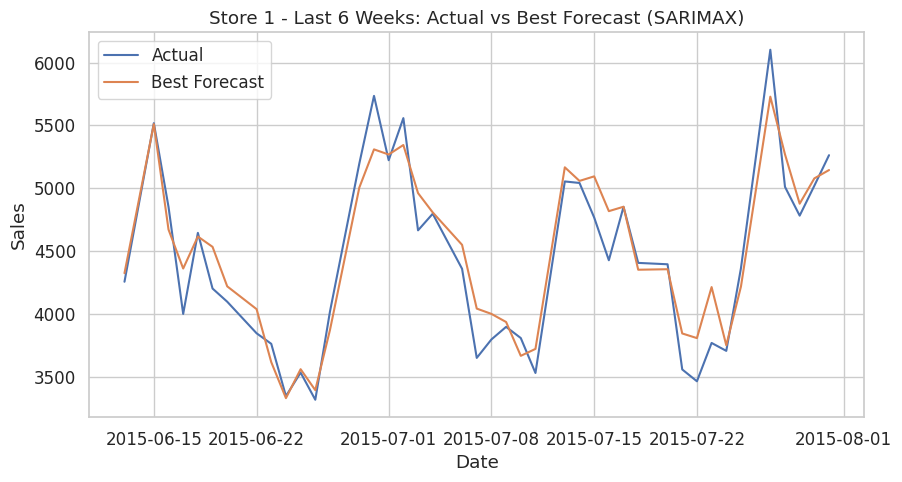

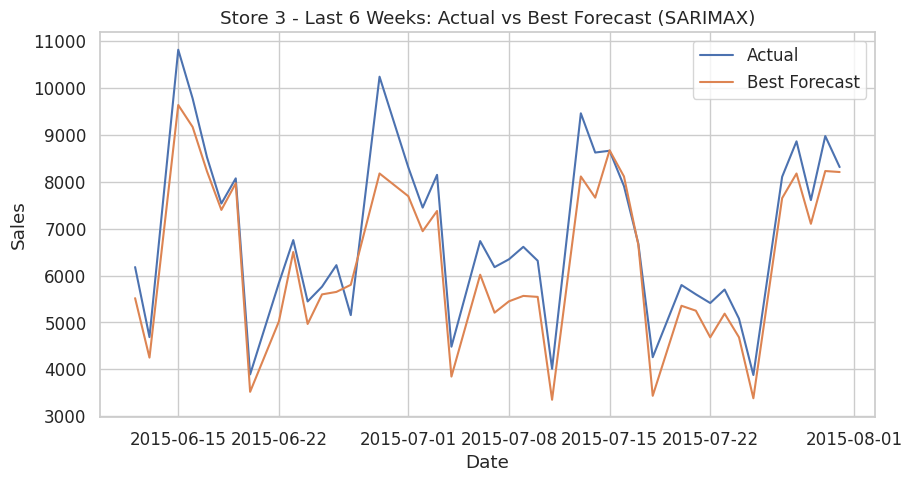

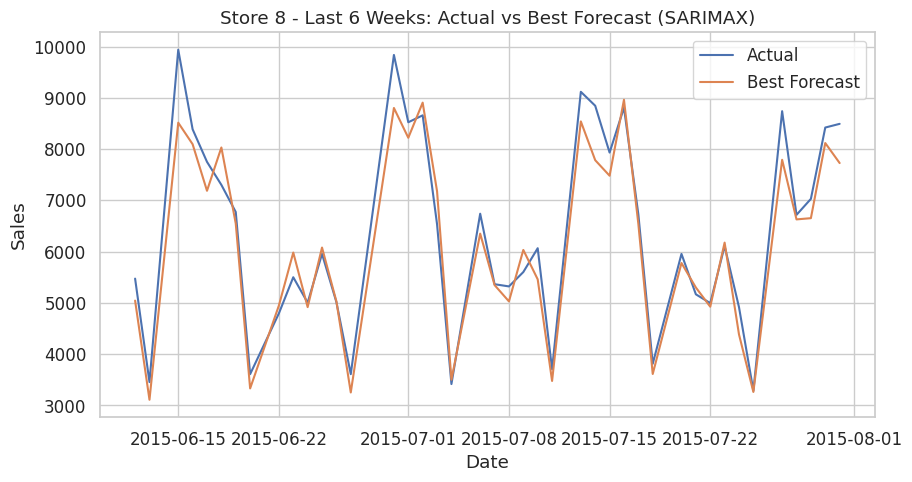

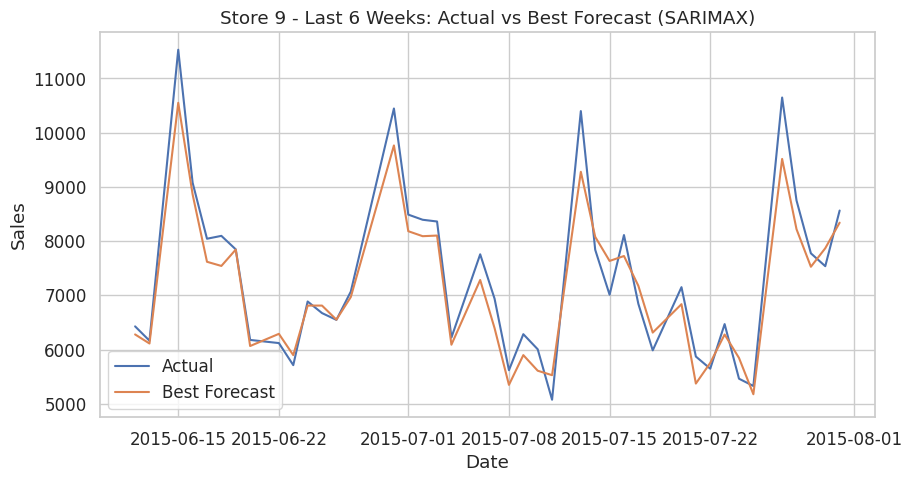

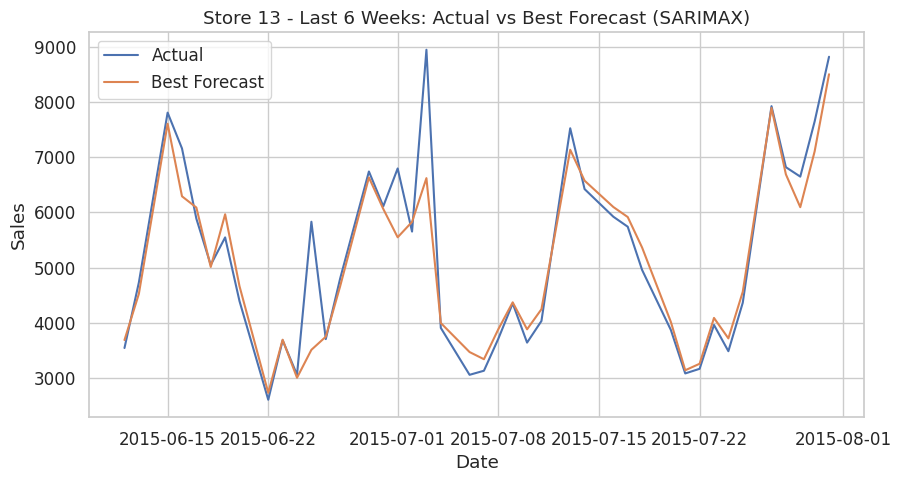

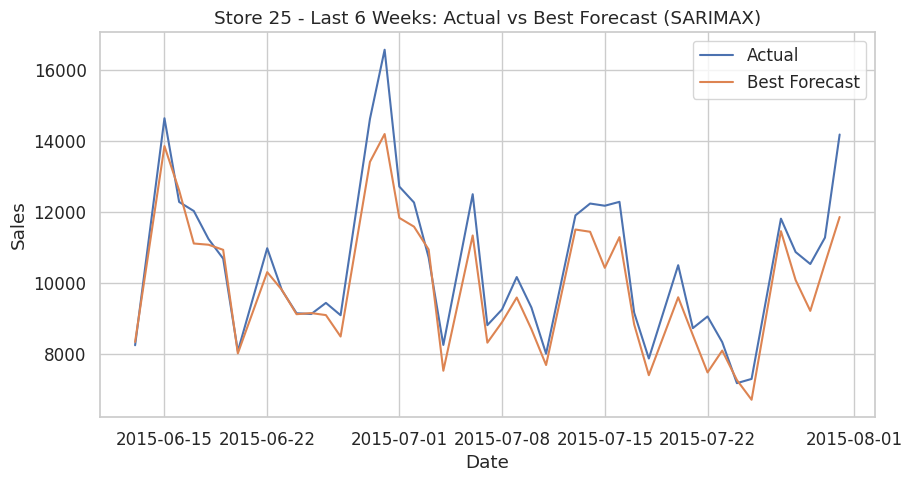

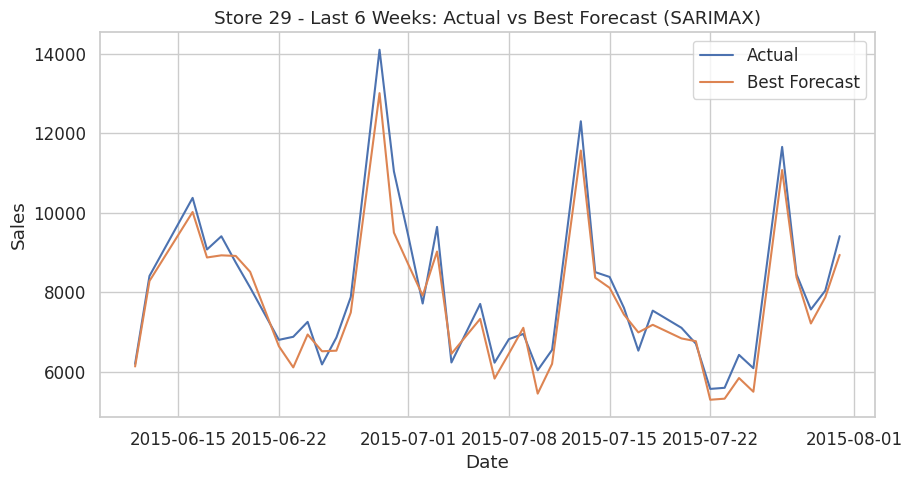

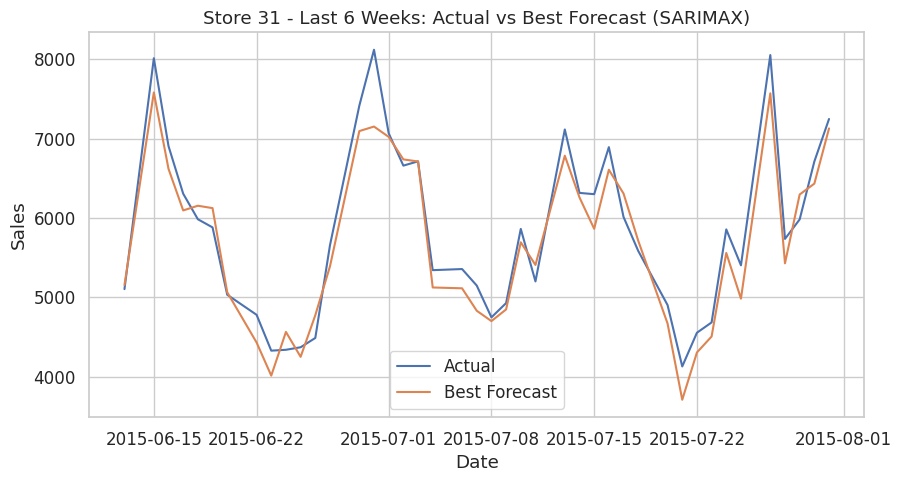

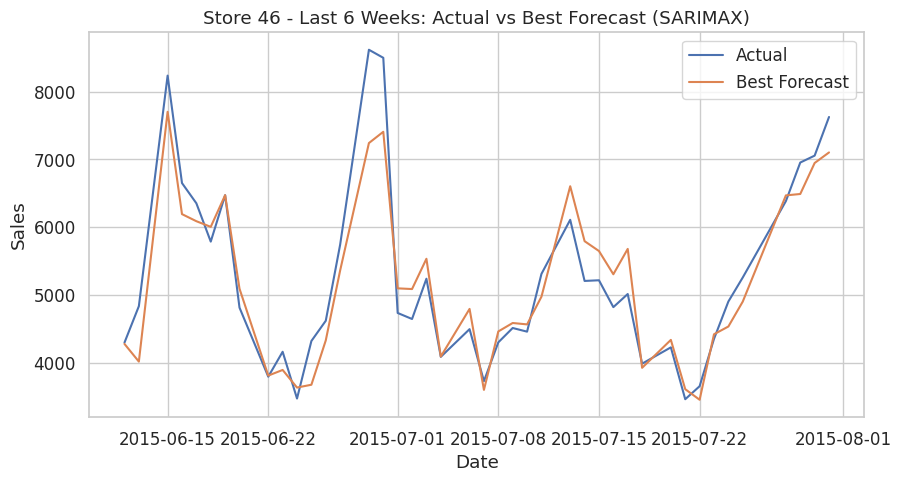

In [78]:
mape_summary_rows = []

for store_id, info in best_models.items():
    mape_summary_rows.append({'Store': store_id, 'BestModel': info['name'], 'MAPE': info['mape']})

mape_summary = pd.DataFrame(mape_summary_rows).set_index('Store').sort_index()

print("\n=== Best model per store ===")
display(mape_summary)

overall_mape = mape_summary['MAPE'].mean() if not mape_summary.empty else np.nan
print(f"Overall average MAPE across stores (best models): {overall_mape:.2f}%")

# Plot last 6 weeks: Actual vs Best Forecast per store
for r in all_store_results:
    store_id = r['store']
    details = r['details']
    plt.figure()
    plt.plot(details['Date'], details['ActualSales'], label='Actual')
    plt.plot(details['Date'], details['BestForecast'], label='Best Forecast')
    plt.title(f"Store {store_id} - Last 6 Weeks: Actual vs Best Forecast ({best_models[store_id]['name']})")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

### <font color="Green">**Impact Analysis**

In [79]:
impact_results = {}

for store_id, group in df_std.groupby('Store'):

    store_data = group.sort_values('Date').copy()
    # Create log-transformed variables
    store_data['log_sales'] = np.log1p(store_data['Sales'])
    store_data['log_customers'] = np.log1p(store_data['Customers'])

    # Simple interpretable regression
    formula = 'log_sales ~ log_customers + Promo + Promo2 + DayOfWeek'
    model = smf.ols(formula, data=store_data).fit()

    impact_results[store_id] = model

    print("\n==========================")
    print(f"Store {store_id} - Impact Regression")
    print(model.summary().tables[1])

for store_id in impact_results:
    model = impact_results[store_id]
    print(f"\n=== Interpretation example: Store ", store_id, " === ")
    print("Coeff log_customers:", model.params.get('log_customers', np.nan))
    print("Coeff Promo:", model.params.get('Promo', np.nan))


Store 1 - Impact Regression
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.3663      0.097     14.048      0.000       1.175       1.557
log_customers     1.1119      0.016     71.154      0.000       1.081       1.143
Promo             0.1002      0.005     20.756      0.000       0.091       0.110
Promo2                 0          0        nan        nan           0           0
DayOfWeek         0.0010      0.001      0.779      0.436      -0.002       0.004

Store 3 - Impact Regression
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1440      0.055     20.925      0.000       1.037       1.251
log_customers     0.9718      0.016     59.275      0.000       0.940       1.004
Promo             0.1990      0.007     

# <font color="Orange">**8. Final 6 Weeks Forecast**

### <font color="Green">**8.1 Model Forecast Functions**

##### <font color="DarkRed">**8.1.1 Forecast using SARIMAX**

In [67]:
def forecast_sarimax(data, order, forecast_days, exog=None):

    model = SARIMAX(data, order=order, seasonal_order=(1,0,1,7), exog=exog)
    model_fit = model.fit()

    last_exog = exog.iloc[-1:]
    future_exog = pd.concat([last_exog] * forecast_days, ignore_index=True)

    forecast  = model_fit.get_forecast(steps=forecast_days, exog=future_exog)

    return forecast

##### <font color="DarkRed">**8.1.2 Forecast using ARIMA**

In [68]:
def forecast_arima(data, order, forecast_days, exog_cols=None):

    model = ARIMA(data, order=order)
    model_fit = model.fit()

    last_exog = data[exog_cols].iloc[-1:]
    future_exog = pd.concat([last_exog] * forecast_days, ignore_index=True)

    forecast  = model_fit.forecast(start=len(data), end=len(data) + forecast_days)

    return forecast

##### <font color="DarkRed">**8.1.2 Forecast using VAR/VECM**

In [69]:
# Refit VAR or VECM on full standardized [Sales_Std, Customers_Std] history
def forecast_var_vecm(g, model_name, params, store_id, store_coint, scalers,
                           horizon=forecast_days):

    endog_all = g[["Sales_Std", "Customers_Std"]]

    # Refitting based on best model type and its params
    if model_name == "VECM":
        cinfo = store_coint.get(store_id, {"k_ar_diff": 1, "rank": 0})
        k_ar_diff = cinfo["k_ar_diff"] or 1
        rank = cinfo["rank"]
        model = VECM(endog_all, k_ar_diff=k_ar_diff, coint_rank=rank, deterministic="ci")
        res = model.fit()
        fc_std = res.predict(steps=horizon)
        sales_std_fc = np.array(fc_std)[:, 0]
    else:  # VAR
        p = params.get("p", 1)
        var_model = VAR(endog_all)
        res = var_model.fit(p)
        fc_vals = res.forecast(endog_all.values[-p:], steps=horizon)
        sales_std_fc = np.array(fc_vals)[:, 0]

    # Inverse standardization back to original Sales
    scaler = scalers[store_id]
    sales_mean = scaler.mean_[0]
    sales_std = scaler.scale_[0]
    sales_fc = sales_std_fc * sales_std + sales_mean

    return pd.Series(sales_fc)

In [70]:
# Generate a DatetimeIndex for future forecast horizon
def make_future_index(last_date, horizon=forecast_days, freq="D"):
    return pd.date_range(start=last_date + pd.Timedelta(days=1),
                         periods=horizon, freq=freq)

### <font color="Green">**8.2 Store ForeCast Functions**

##### <font color="DarkRed">**8.2.1 ForeCast Each Store**

In [71]:
def forecast_store(df_store, store_last_index, store_id, best_models,
                   scalers, store_coint, exog_cols, horizon=forecast_days):

    best_model_info = best_models[store_id]
    best_model_name = best_model_info['name']
    params = best_model_info['params']
    future_index = make_future_index(store_last_index, horizon=horizon)
    if best_model_name == 'SARIMAX':
            order = params['order']
            forecast_result = forecast_sarimax(df_store['Sales'], order,
                                               forecast_days, df_store[exog_cols])
            forecast_mean = forecast_result.predicted_mean
            forecast_series = pd.Series(forecast_mean.values, index=future_index)
            #print("/n--Forecast Series: ", forecast_series)

    elif best_model_name == 'VECM':
              forecast_series = forecast_var_vecm(df_store, best_model_name, params, store_id,
                                                store_coint, scalers)
    result =  pd.DataFrame({
              "Store": store_id,
              "Date": future_index,
              "ForecastSales": forecast_series.values
      })
    #print(result.head(10))
    return result

##### <font color="DarkRed">**8.2.2 ForeCast All Stores**

In [72]:
def forecast_all_stores(df_std):

    all_forecasts = []

    for store_id in df_std['Store'].unique():

        store_data = df_std[df_std["Store"] == store_id].sort_values("Date").copy()
        store_data["Date"] = pd.to_datetime(store_data["Date"])
        store_data = store_data.set_index("Date")

        forecast = forecast_store(store_data, store_data.index.max(), store_id,
                                  best_models, scalers, store_coint, exog_cols)
        #print("Train mean sales:", train["Sales"].mean())
        #print("Last 6-week mean:", test["Sales"].mean())
        #print("Forecast mean:", forecast['ForecastSales'].mean())
        #print("Forecast min/max:", forecast.min(), forecast.max())
        all_forecasts.append(forecast)

    final_fc = pd.concat(all_forecasts, ignore_index=True)
    return final_fc

### <font color="Green">**8.3 Plot Store History and Foreast**

##### <font color="DarkRed">**8.3.1 History and Forecast Graph**

In [73]:
def plot_history_and_forecast(df_std, store_id, forecase_df, history_days=180):

    df_store = df_std[df_std['Store'] == store_id]

    history_data = df_store.iloc[-history_days:]
    fc_store = forecase_df[forecase_df['Store'] == store_id]

    plt.figure(figsize=(12, 5))
    plt.plot(history_data['Date'], history_data['Sales'], label='History')
    plt.plot(fc_store['Date'], fc_store['ForecastSales'], label='Forecast - Next 6 Weeks')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Store {store_id} - History and Forecast')
    plt.show()

##### <font color="DarkRed">**8.3.2 Generate and Display**

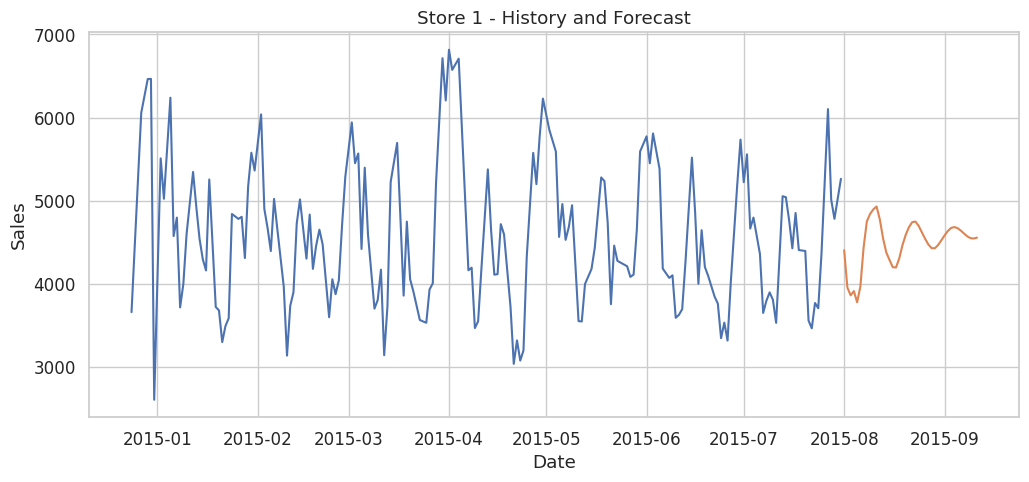

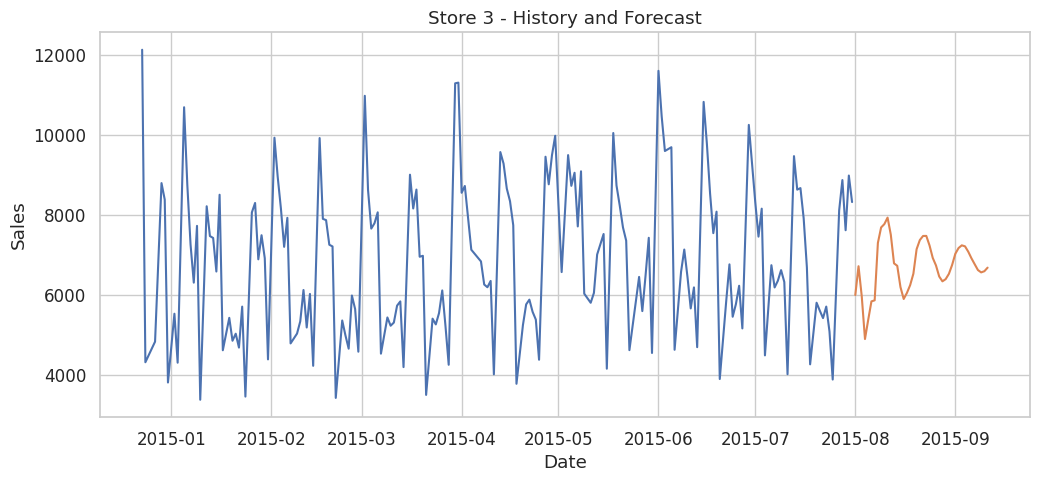

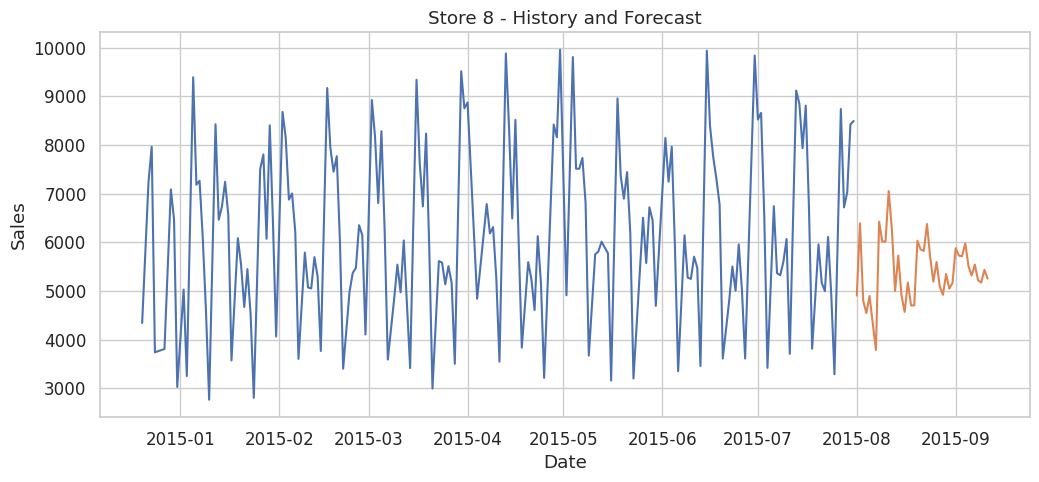

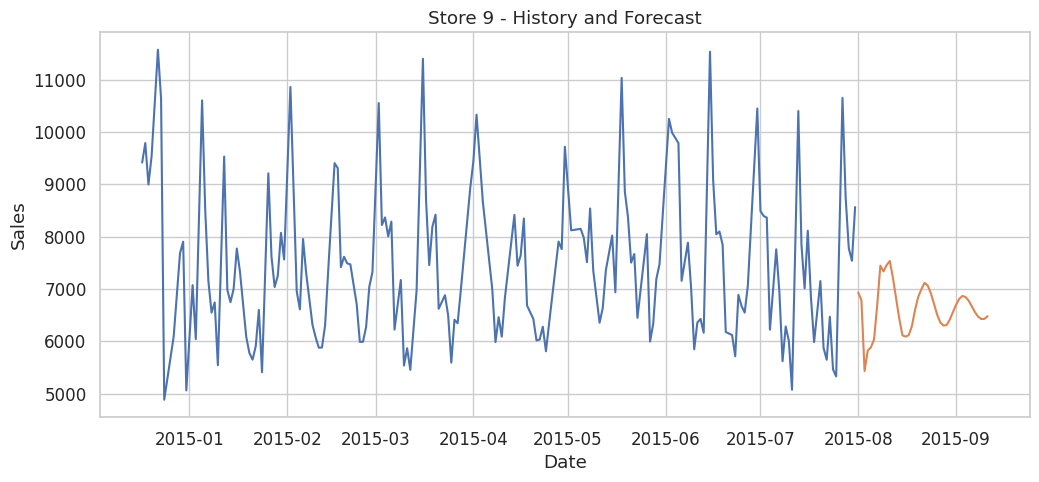

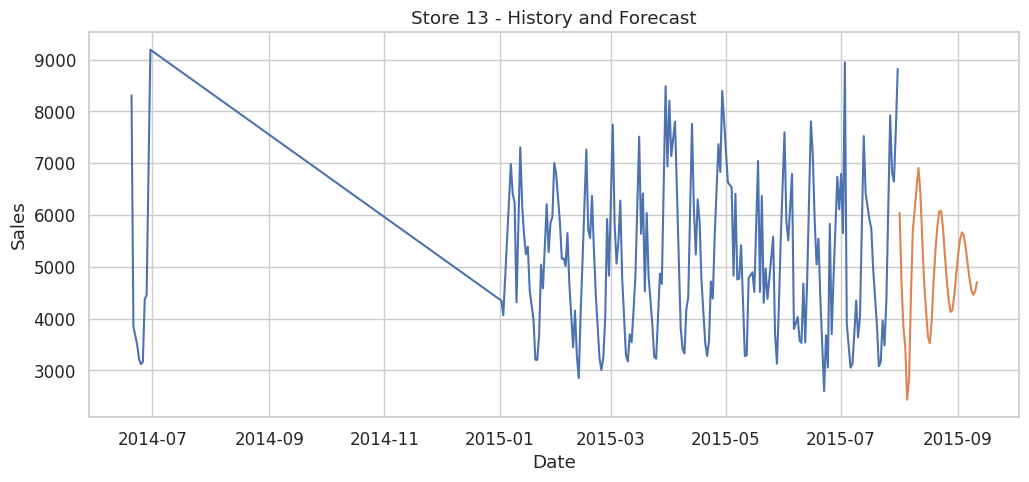

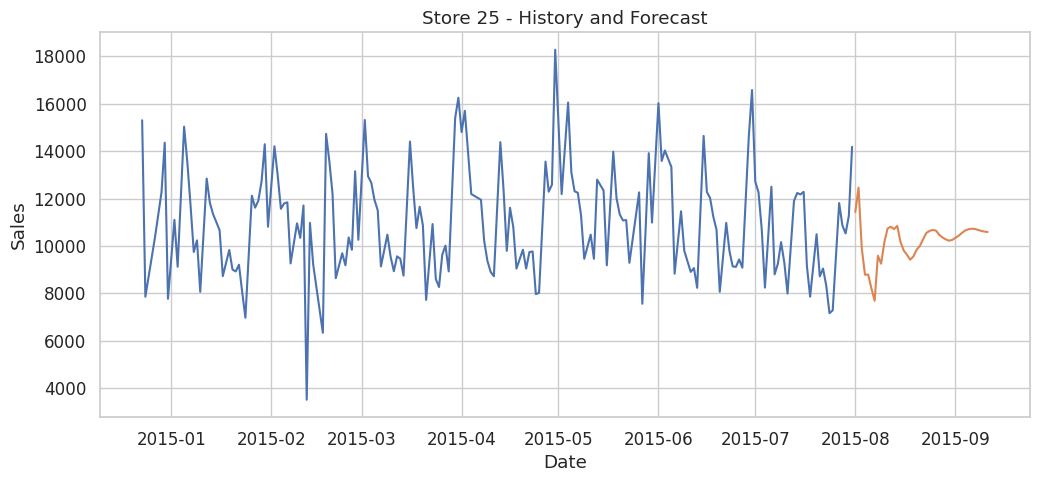

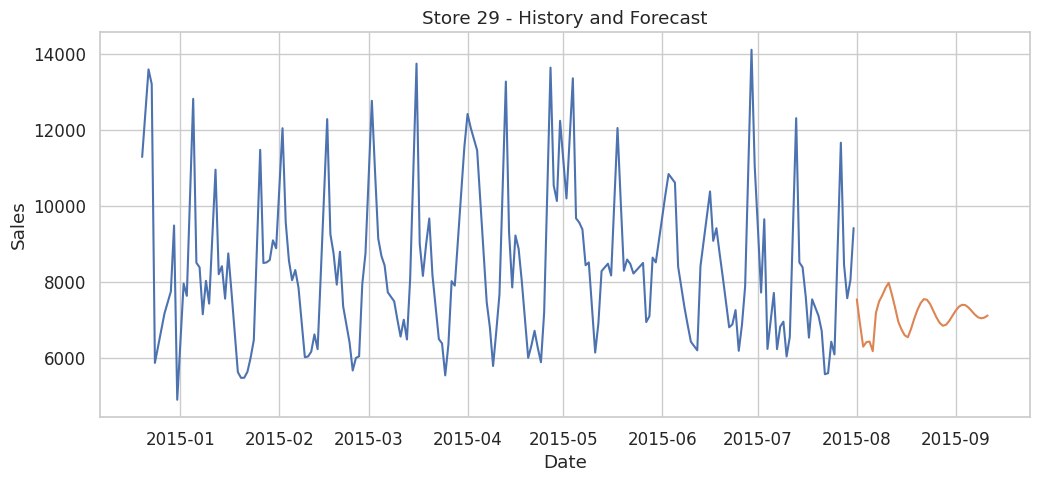

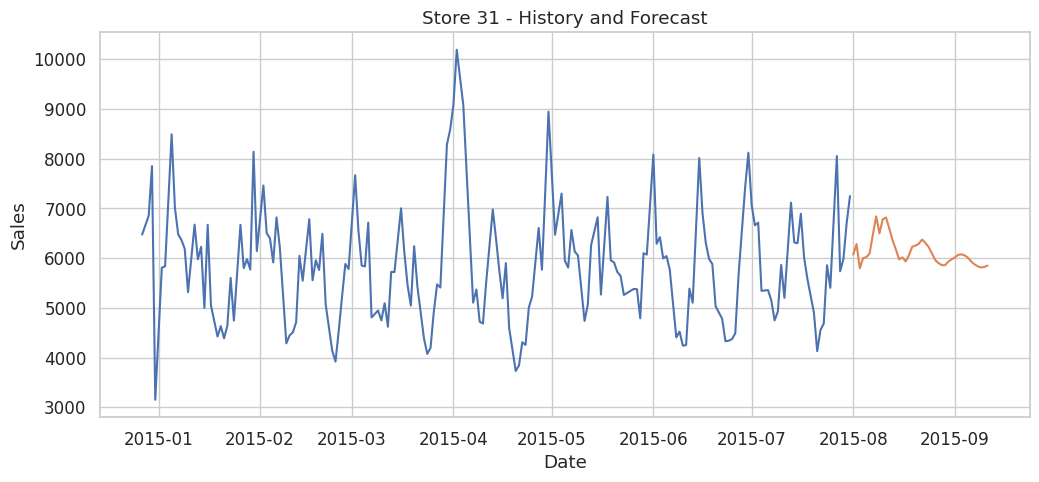

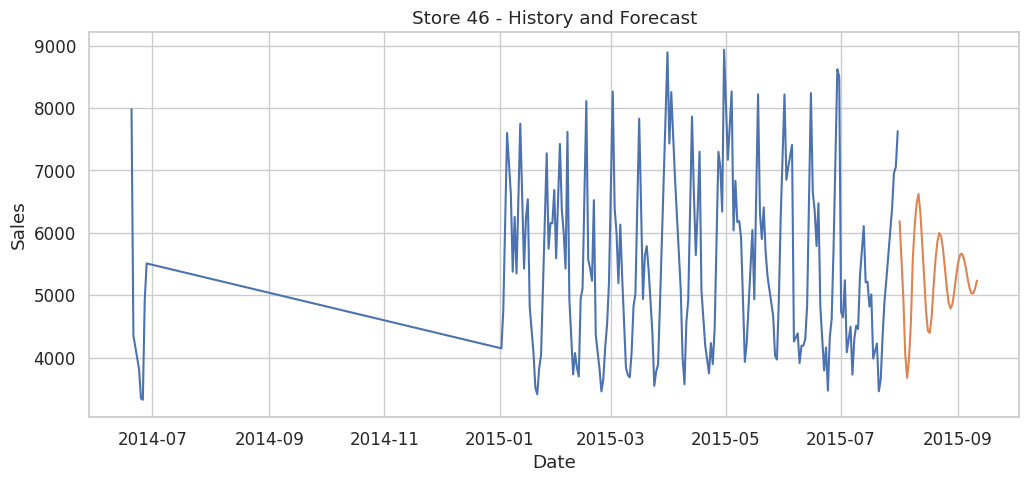

In [81]:
forecasts_df = forecast_all_stores(df_std)

for store_id in df_std['Store'].unique():
    plot_history_and_forecast(df_std, store_id, forecasts_df, 180)

# <font color="Orange">**Short Summary**
###   <font color="Green">**Stationarity**: <font color="Black">**All series across all stores rejected the null hypothesis at 5% significance level, indicating the standardized series are stationary.**

### <font color="Green">**Johansen Cointegration Test:**<font color="Black">**Rank = 2 indicates full rank, meaning both Sales and Customers are already stationary (I(0)). This supports using VECM with cointegration constraints.**

### <font color="Green">**Models Evaluated:**  

*   **Last Value Forecast: Baseline using last observed value**
*   **ARIMA: Autoregressive Integrated Moving Average with grid search**
*   **SARIMA: Seasonal ARIMA without exogenous variables**
*   **SARIMAX: SARIMA with exogenous variables (Customers, Promo, Promo2Active, Weekend)**

### <font color="Green">**Key Findings**
*   **MAPE ranging from 3.96% to 9.10%.**
*   **Exogenous variables significantly improve forecast accuracy. The inclusion of Customers, Promo, Promo2Active, and Weekend reduces MAPE by 10-20 percentage points compared to univariate models.**
